## <font color=blue>Contents<font/>

#########################################################################################################

1. **Jupyter setup <br>**
2. **Exploratory Data Analysis (part 2) <br>**
    * **Inspect Distributions**
    * **Remove Outlier Rows and Rerun Distribution Plots** <br><br>
3. **Hypothesis Testing**

#########################################################################################################

## <font color=blue>Jupyter Setup<font/>

###  Import required libraries:

In [1]:
import requests
import sqlite3
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy import stats
import researchpy as rp
import statsmodels.api as sm
import pylab
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.formula.api import ols
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings
from statsmodels.stats.power import TTestIndPower, TTestPower

In [2]:
pd.set_option('display.max_columns', 50)

In [3]:
df_reduced = pd.read_csv('Movies2018_cleaned.csv', engine='python')

In [4]:
df_reduced.head()

,popularity,vote_count_x,vote_average_x,release_date,original_language_x,genre_ids,belongs_to_collection,budget,production_companies,production_countries,revenue,day_of_week,month,quarter,en_int_lang,collection
0,82.250,16683.0,8.3,2018-04-25,en,Adventure|Action|Science Fiction|,The Avengers Collection,300000000.0,Marvel Studios,US,2.046240e+09,2,4,2,en,Collection
1,38.895,14192.0,7.4,2018-02-13,en,Adventure|Fantasy|Action|Science Fiction|,Black Panther Collection,200000000.0,Marvel Studios,US,1.346739e+09,1,2,1,en,Collection
2,31.957,6878.0,6.5,2018-06-06,en,Adventure|Action|Science Fiction|,Jurassic Park Collection,170000000.0,Amblin Entertainment,US,1.303460e+09,2,6,2,en,Collection
3,30.431,7607.0,7.5,2018-06-14,en,Adventure|Animation|Action|Family|,The Incredibles Collection,200000000.0,Walt Disney Pictures,US,1.241891e+09,3,6,2,en,Collection
4,31.991,7849.0,6.8,2018-12-07,en,Adventure|Fantasy|Action|,Aquaman Collection,160000000.0,DC Comics,AU,1.143689e+09,4,12,4,en,Collection


In [5]:
df_reduced.columns

Index(['popularity', 'vote_count_x', 'vote_average_x', 'release_date',
       'original_language_x', 'genre_ids', 'belongs_to_collection', 'budget',
       'production_companies', 'production_countries', 'revenue',
       'day_of_week', 'month', 'quarter', 'en_int_lang', 'collection'],
      dtype='object')

In [6]:
categoricals = ['original_language_x', 'genre_ids', 'belongs_to_collection',
                'production_companies', 'production_countries', 'day_of_week', 
                'month', 'quarter', 'en_int_lang', 'collection']
len(categoricals)

10

## Set up definitions for statistical tests

In [7]:
# Welch t-test

def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.8f}", "\n",
          f"Degrees of Freedom= {dof:.4f}")

In [8]:
# Cohen's D for measuring effect size

def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return ddef 

In [9]:
# Mann Whitney U test for pairwise comparison of non-parametrics

def mann_whitney_u(x, y):
    stat, p = mannwhitneyu(x, y)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [10]:
# Anova test

def anova(formula, dataframe):
    lm = ols(formula, dataframe).fit()
    table = sm.stats.anova_lm(lm)
    def anova_table(table):
        table['mean_sq'] = table[:]['sum_sq']/table[:]['df']
        table['eta_sq'] = table[:-1]['sum_sq']/sum(table['sum_sq'])
        table['omega_sq'] = (table[:-1]['sum_sq']-(table[:-1]['df']*table['mean_sq'][-1]))/(sum(table['sum_sq'])+table['mean_sq'][-1])
        cols = ['sum_sq', 'df', 'mean_sq', 'eta_sq', 'omega_sq', 'F', 'PR(>F)']
        table=table[cols]
        return table
    return anova_table(table)
    

In [11]:
# Dunn Test

def dunn_test(data_list):
    return sp.posthoc_dunn(data_list, p_adjust='holm')

In [12]:
# Tukey Test

def tukey_test(dependent, independent):
    mc = MultiComparison(dependent, independent)
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [13]:
def kw_test(*args):
    stat, p = kruskal(*args)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print('Different distributions (reject H0)')

### check outliers for continuous variables

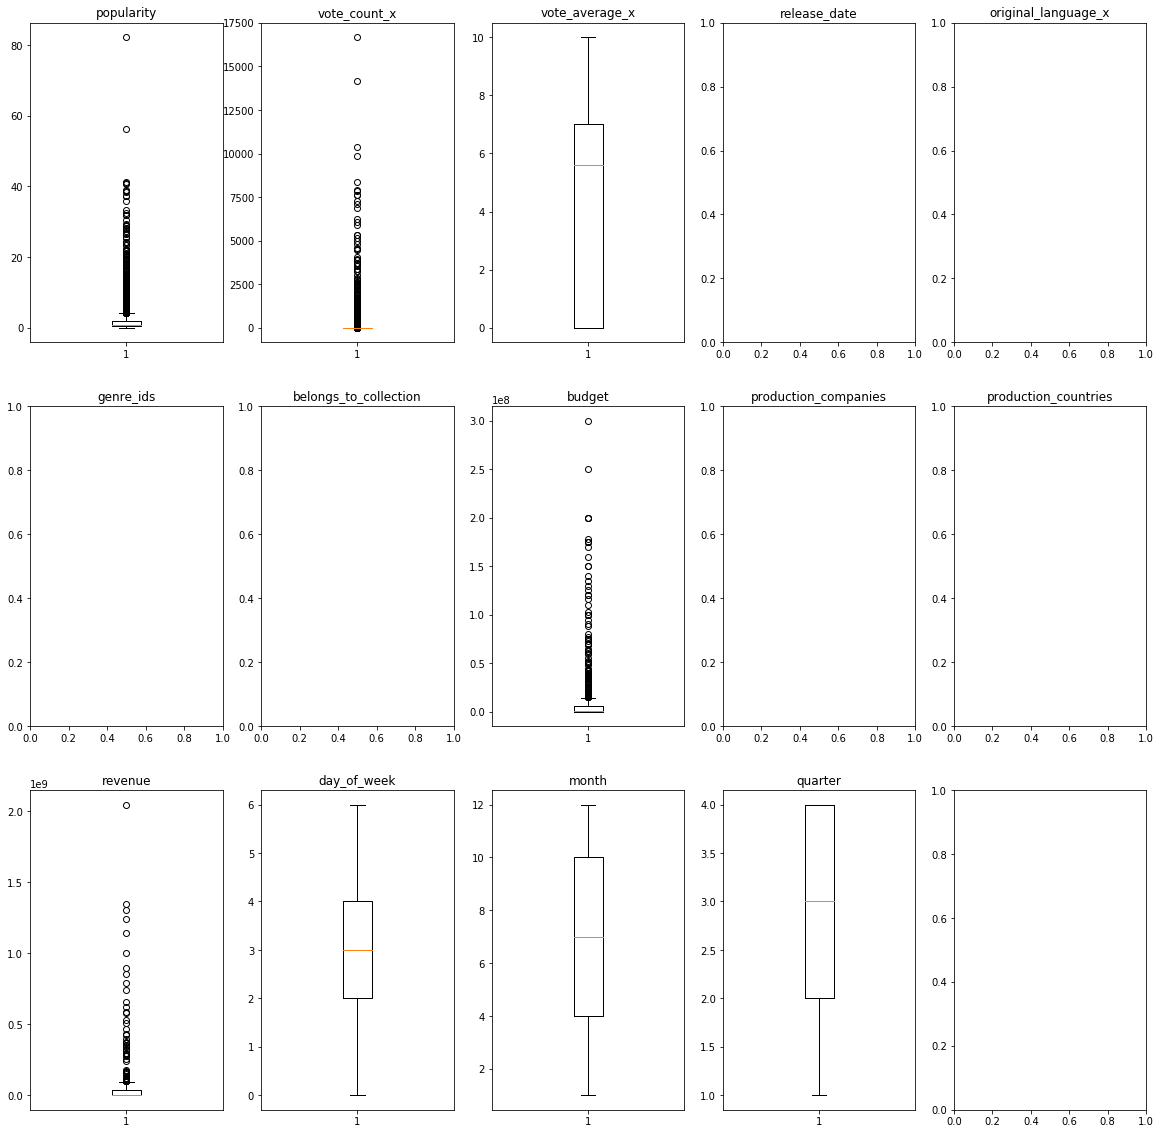

In [14]:
fig2, axes2 = plt.subplots(3, 5, figsize = (20,20))
axes2.shape

for n in range(1,15):
    
    i = df_reduced.dtypes.index[n-1]
    
    row = (n-1)//5
    col = (n-1)%5
    
    if str(i) in ['budget', 'revenue']:
        ax = axes2[row][col]
        ax.boxplot(df_reduced[str(i)].loc[df_reduced[str(i)] > 0])
        ax.set_title('{}'.format(i))
        
    elif str(type(df_reduced[str(i)][0])) in ["<class 'numpy.float64'>", "<class 'numpy.int64'>"]:
        ax = axes2[row][col]
        ax.boxplot(df_reduced[str(i)])
        ax.set_title('{}'.format(i))
    else:   
        ax = axes2[row][col]
        ax.set_title('{}'.format(i))
        continue

###   Inspect Distributions

In [15]:
df_vote_average = df_reduced.loc[df_reduced['vote_count_x'] >= 30] 

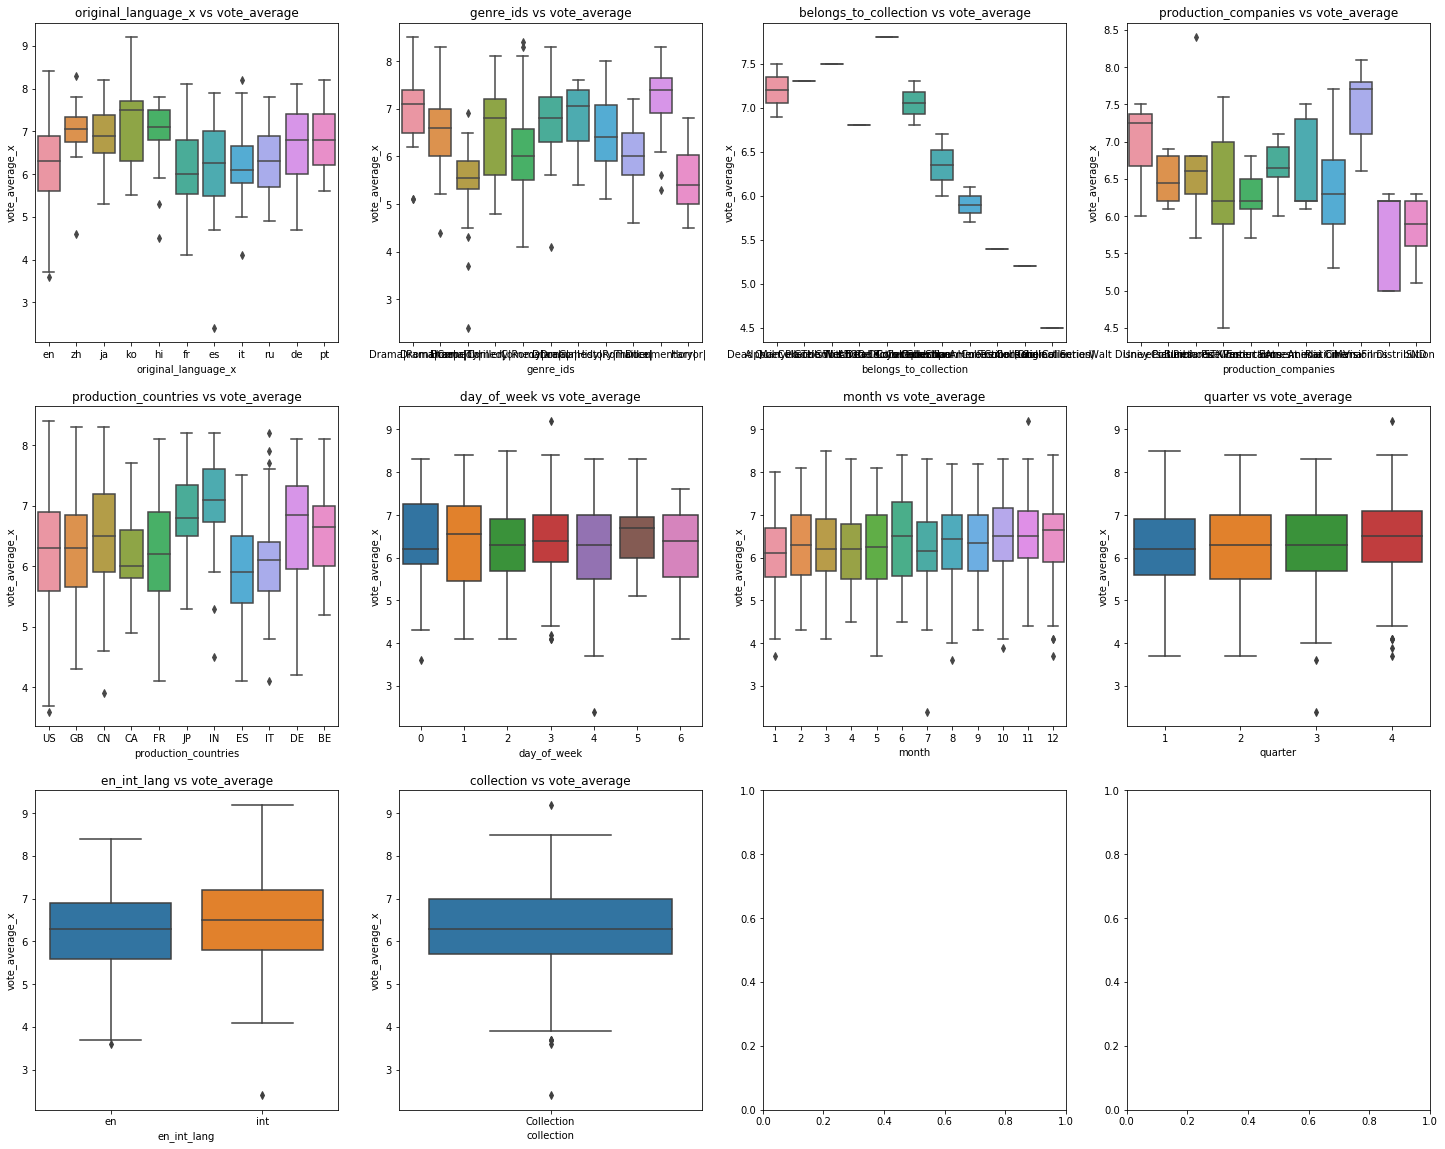

In [16]:
fig3, axes3 = plt.subplots(3, 4, figsize = (25,20))
axes3.shape

for n in range(1,11):
    
    i = categoricals[n-1]
    
    row = (n-1)//4
    col = (n-1)%4
    
    if str(type(df_vote_average[str(i)][0])) in ["<class 'numpy.float64'>", "<class 'numpy.int64'>"]:
        
        if (len(df_vote_average[str(i)].unique()) > 12):
            
            ax = axes3[row][col]
            ax.scatter(df_vote_average[str(i)], df_vote_average['vote_average_x'])
            ax.set_title('{}'.format(i) + ' vs vote_average')
            
        
        else:
            ax = axes3[row][col]
            sns.boxplot(str(i), 'vote_average_x', data=df_vote_average, ax=ax)
            ax.set_title('{}'.format(i) + ' vs vote_average')
    
    elif (len(df_vote_average[str(i)].unique()) > 12):
        
        top10 = list(df_vote_average[str(i)].loc[df_vote_average[str(i)] != 'na'].value_counts()[0:11].index)
        
        top10_df = df_vote_average[df_vote_average[str(i)].isin(top10)]
        
        ax = axes3[row][col]
        sns.boxplot(str(i), 'vote_average_x', data=top10_df, ax=ax)
        ax.set_title('{}'.format(i) + ' vs vote_average') 
            
        
    else:
            ax = axes3[row][col]
            sns.boxplot(str(i), 'vote_average_x', data=df_vote_average, ax=ax)
            ax.set_title('{}'.format(i) + ' vs vote_average') 

Categories of initial interest are: en_int_lang, genre_ids, quarter and month

In [17]:
categories_of_further_interest = ['en_int_lang', 'genre_ids', 'quarter', 'month']

en_int_lang , en NormaltestResult(statistic=5.1460343744506245, pvalue=0.07630497137143663)
en_int_lang , int NormaltestResult(statistic=4.65542416075279, pvalue=0.09751860678391161)
genre_ids , Comedy| NormaltestResult(statistic=4.084045823354522, pvalue=0.12976594015140538)
genre_ids , Drama| NormaltestResult(statistic=4.870463577202151, pvalue=0.08757744524176653)
genre_ids , Drama|Comedy| NormaltestResult(statistic=0.6469928201872197, pvalue=0.7236145556262367)
genre_ids , Documentary| NormaltestResult(statistic=6.004884885099243, pvalue=0.04966561469584742)
genre_ids , Horror|Thriller| NormaltestResult(statistic=16.66106272647722, pvalue=0.00024104392896078907)
genre_ids , Comedy|Romance| NormaltestResult(statistic=0.7204206321251148, pvalue=0.6975296089622154)
genre_ids , Thriller| NormaltestResult(statistic=0.2645620800012429, pvalue=0.8760947428105613)
genre_ids , Drama|Comedy|Romance| NormaltestResult(statistic=2.6414427328440597, pvalue=0.26694266901669744)
genre_ids , Drama|

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))
/Users/apple/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


genre_ids , Drama|History| NormaltestResult(statistic=1.4784916463421958, pvalue=0.47747387950205233)
quarter , 3 NormaltestResult(statistic=14.68585336885792, pvalue=0.0006471537318962803)
quarter , 4 NormaltestResult(statistic=3.241022360100775, pvalue=0.19779756306820453)
quarter , 2 NormaltestResult(statistic=5.675377698412538, pvalue=0.05856085264699919)
quarter , 1 NormaltestResult(statistic=1.7063681074288604, pvalue=0.4260561841579651)
month , 9 NormaltestResult(statistic=1.2768246718939904, pvalue=0.5281302521889473)
month , 10 NormaltestResult(statistic=0.7443690951196617, pvalue=0.6892270356191287)
month , 3 NormaltestResult(statistic=0.13498999700991937, pvalue=0.9347323956637773)
month , 8 NormaltestResult(statistic=2.9782261305360773, pvalue=0.2255726350465467)
month , 5 NormaltestResult(statistic=2.6770100060289335, pvalue=0.26223741982603005)
month , 11 NormaltestResult(statistic=1.1305603228864487, pvalue=0.5682009364618882)
month , 4 NormaltestResult(statistic=0.59409

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


month , 6 NormaltestResult(statistic=12.181366347063962, pvalue=0.002263861775946942)
month , 2 NormaltestResult(statistic=2.053429621414668, pvalue=0.35818172461800357)
month , 1 NormaltestResult(statistic=0.7076159948888628, pvalue=0.7020097420809477)
month , 12 NormaltestResult(statistic=5.027242017502316, pvalue=0.08097449837548487)
month , 7 NormaltestResult(statistic=15.990968298565274, pvalue=0.0003369809527352625)


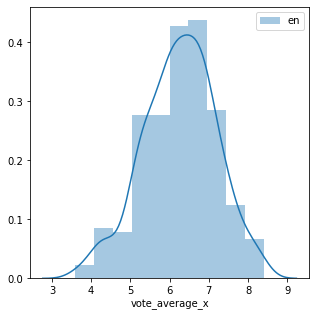

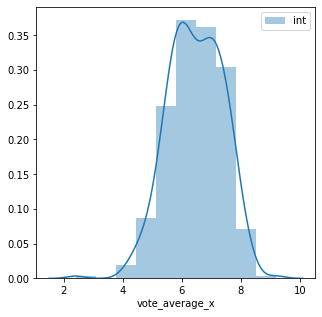

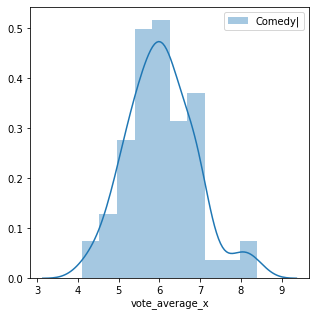

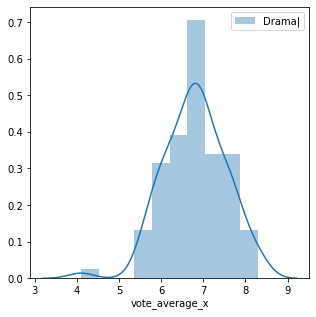

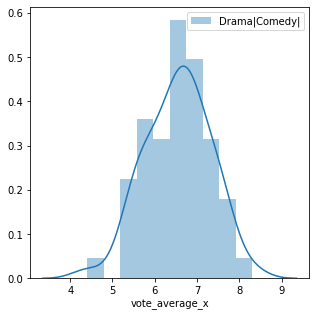

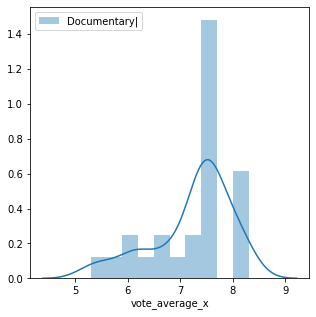

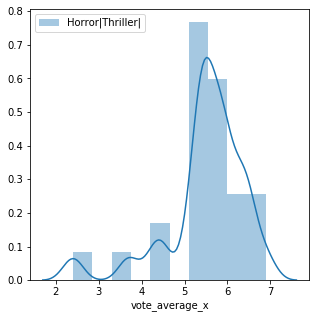

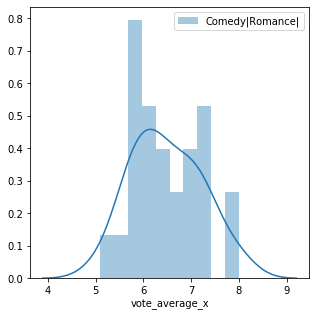

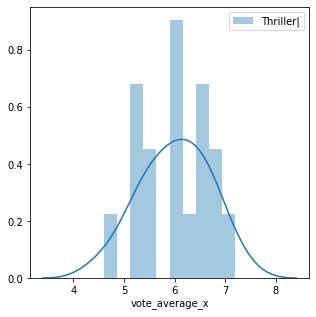

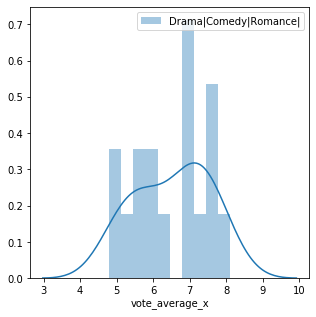

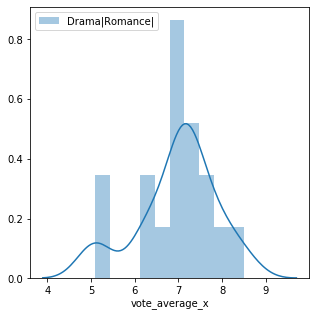

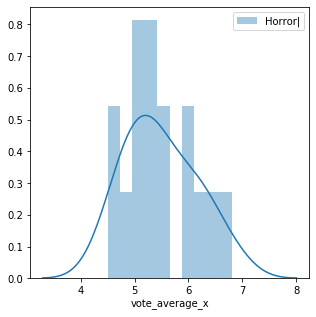

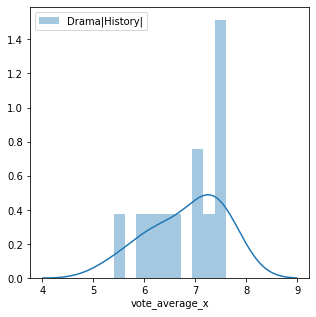

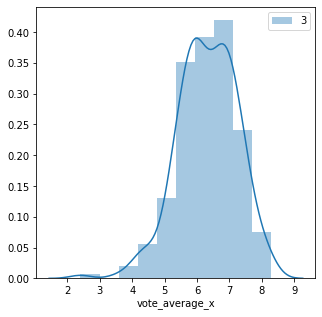

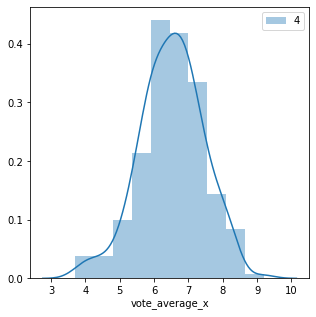

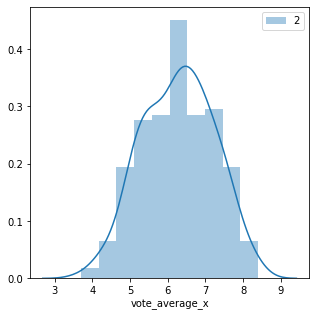

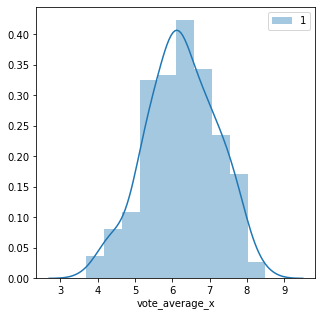

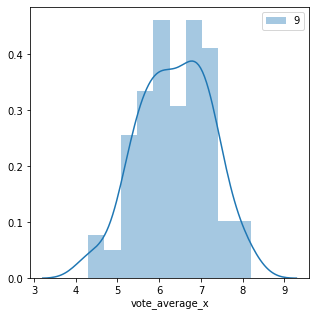

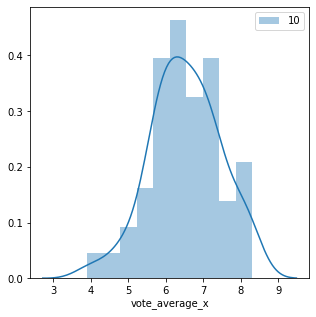

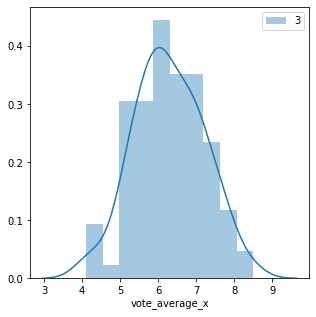

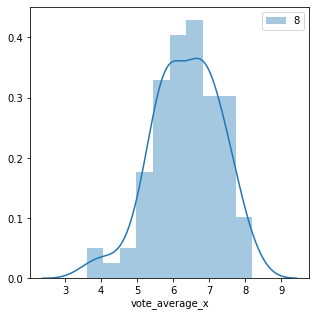

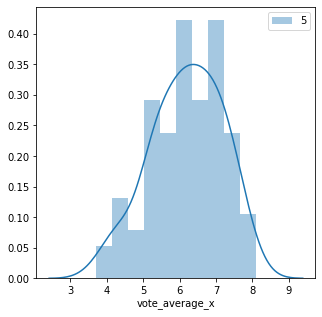

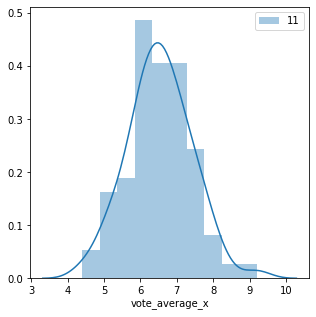

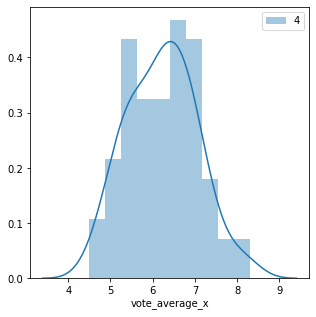

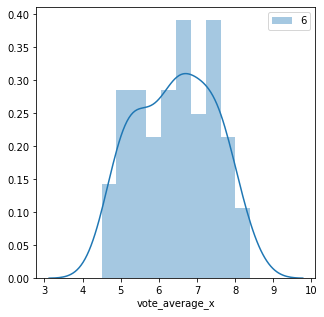

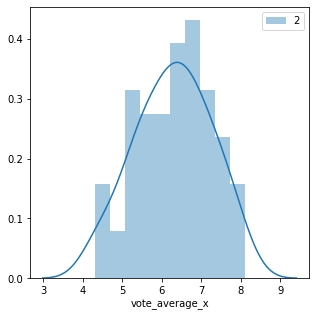

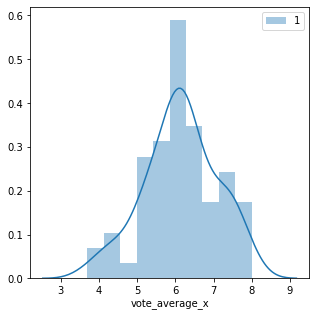

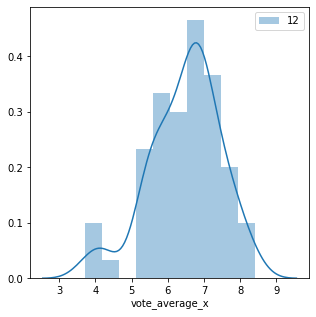

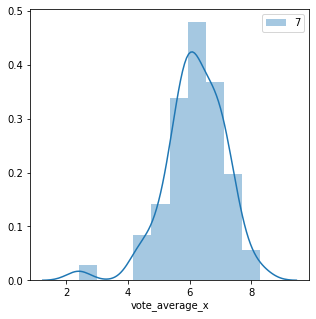

In [18]:
for cat in categories_of_further_interest:
    
    if cat != 'month':
    
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:11].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]

        exec(f'{cat} = top10_df.copy()')
    else:
        
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:13].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]

        exec(f'{cat} = top10_df.copy()')
        
    for i in top10:    
        print(cat, ',', i, stats.normaltest(list(top10_df[top10_df[cat] == i]['vote_average_x'])))
        
        fig = plt.figure(figsize = (5, 5))
        sns.distplot(top10_df[top10_df[cat] == i]['vote_average_x'], bins = 10, label=i)
        plt.legend()

Many of the categories of interests are normally distributed but some are not but close to being normal except for some skewness. So will remove extreme outliers from each category in an attempt to reduce skewness and make more normal.

In [19]:
for cat in categories_of_further_interest:
    
    if cat != 'month':
    
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:11].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]


    else:
        
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:13].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]

        
        
    exec(f"{cat}[str(cat) +  '_outlier_flag'] = 0")
    for i in top10:
    
        exec(f"data_mean, data_std = np.mean({cat}.loc[{cat}[cat] == i]['vote_average_x']), np.std({cat}.loc[{cat}[cat] == i]['vote_average_x'])")   
        cut_off = data_std * 3
        upper, lower = data_mean + cut_off, data_mean - cut_off
    
        exec(f"{cat}.loc[{cat}[cat] == i, (str(cat) +  '_outlier_flag')] = (({cat}.loc[{cat}[cat] == i]['vote_average_x'] >= upper) | ({cat}.loc[{cat}[cat] == i]['vote_average_x'] <= lower))")


en_int_lang , en NormaltestResult(statistic=5.1460343744506245, pvalue=0.07630497137143663)
en_int_lang , int NormaltestResult(statistic=7.580190847881082, pvalue=0.022593445792625778)
genre_ids , Comedy| NormaltestResult(statistic=4.084045823354522, pvalue=0.12976594015140538)
genre_ids , Drama| NormaltestResult(statistic=2.3902320093393423, pvalue=0.3026688411466072)
genre_ids , Drama|Comedy| NormaltestResult(statistic=0.6469928201872197, pvalue=0.7236145556262367)
genre_ids , Documentary| NormaltestResult(statistic=6.004884885099243, pvalue=0.04966561469584742)
genre_ids , Horror|Thriller| NormaltestResult(statistic=4.778953654248388, pvalue=0.09167763458488924)
genre_ids , Comedy|Romance| NormaltestResult(statistic=0.7204206321251148, pvalue=0.6975296089622154)
genre_ids , Thriller| NormaltestResult(statistic=0.2645620800012429, pvalue=0.8760947428105613)
genre_ids , Drama|Comedy|Romance| NormaltestResult(statistic=2.6414427328440597, pvalue=0.26694266901669744)
genre_ids , Drama|R

/Users/apple/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


month , 11 NormaltestResult(statistic=0.35767680444077565, pvalue=0.8362410231714555)
month , 4 NormaltestResult(statistic=0.5940917958354415, pvalue=0.7430099089716409)
month , 6 NormaltestResult(statistic=12.181366347063962, pvalue=0.002263861775946942)
month , 2 NormaltestResult(statistic=2.053429621414668, pvalue=0.35818172461800357)
month , 1 NormaltestResult(statistic=0.7076159948888628, pvalue=0.7020097420809477)
month , 12 NormaltestResult(statistic=5.027242017502316, pvalue=0.08097449837548487)
month , 7 NormaltestResult(statistic=0.15063047463065396, pvalue=0.9274510730548199)


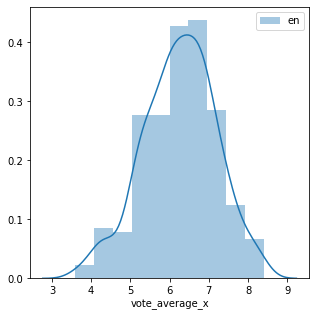

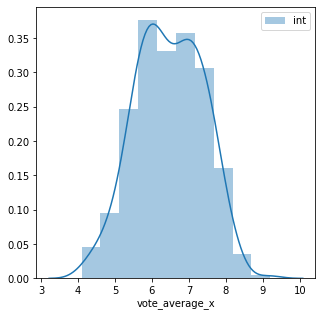

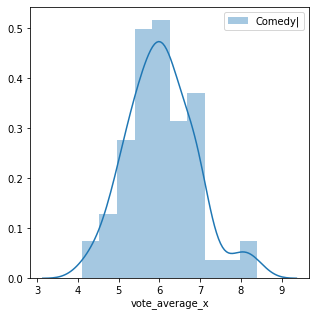

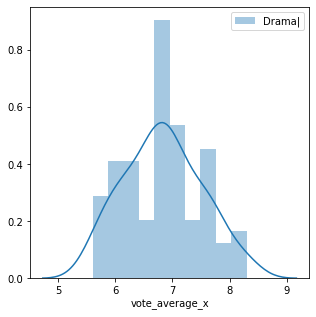

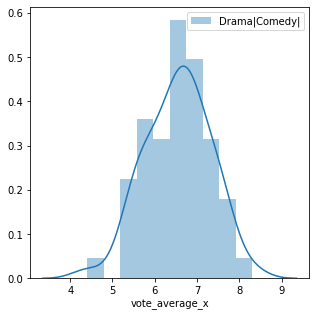

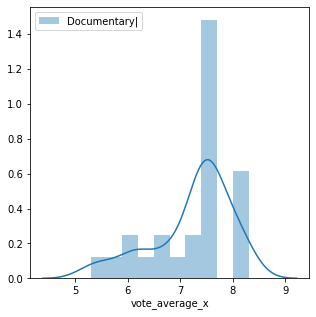

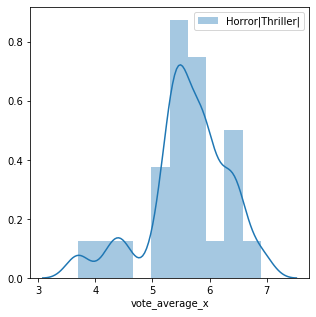

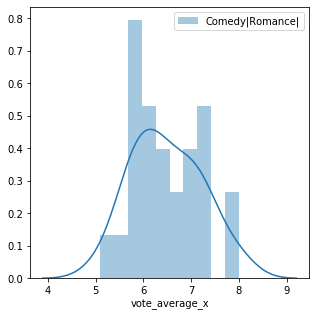

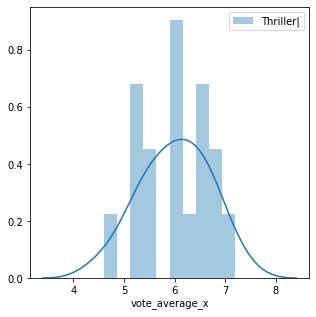

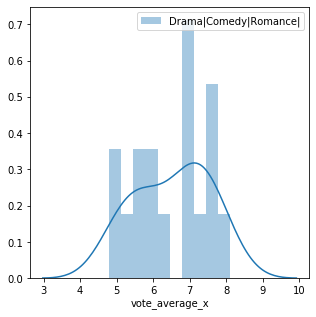

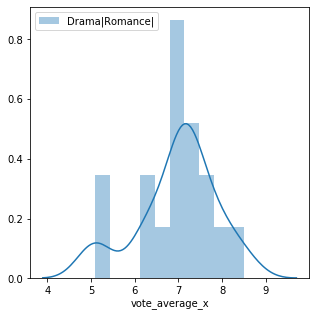

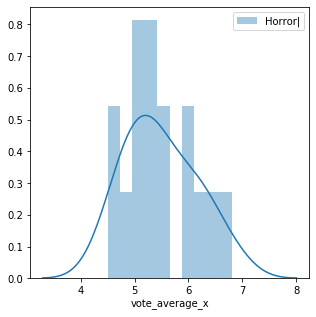

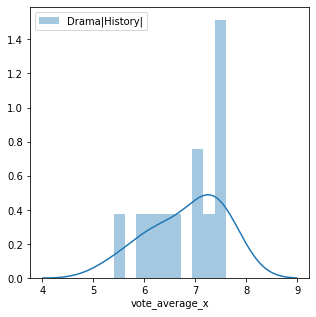

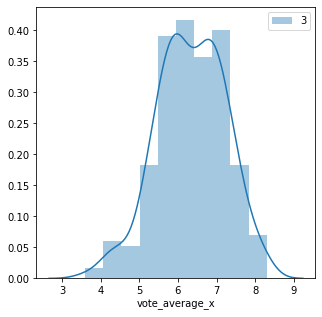

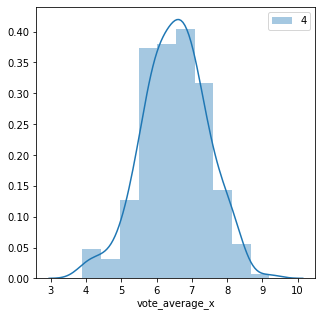

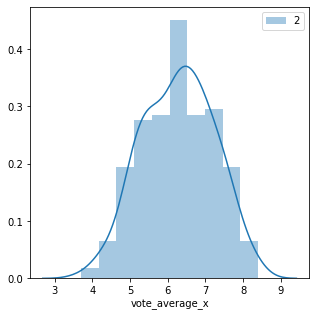

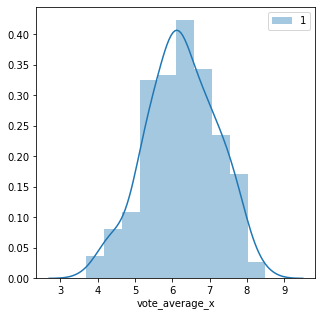

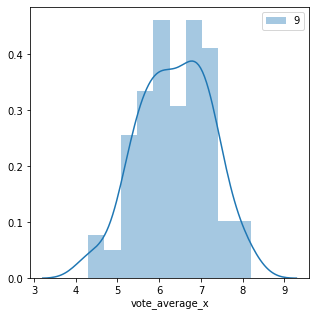

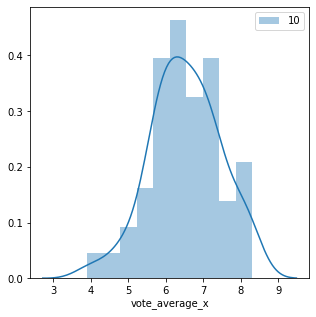

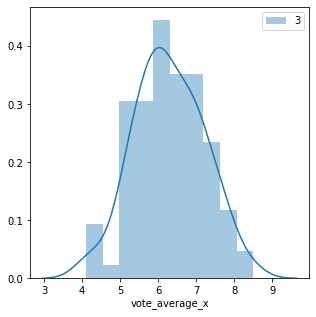

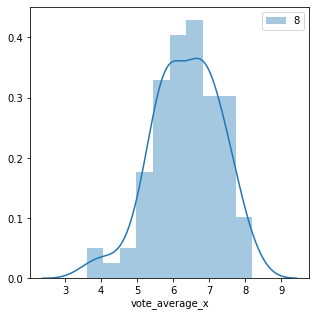

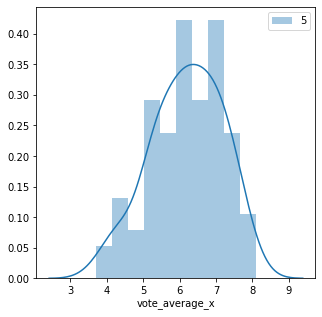

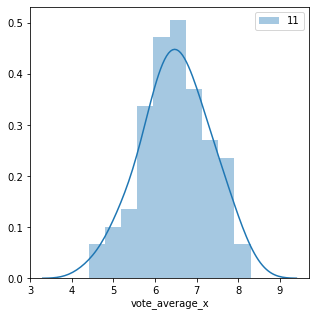

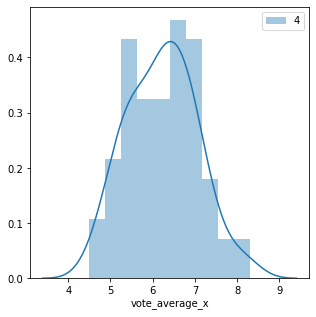

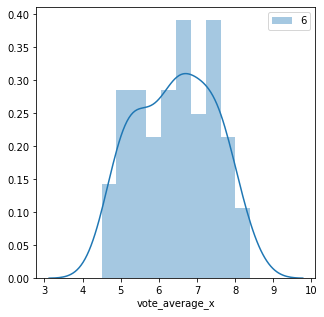

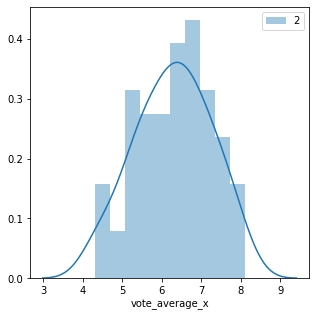

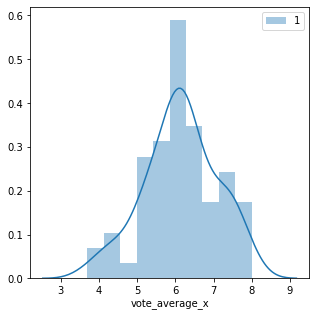

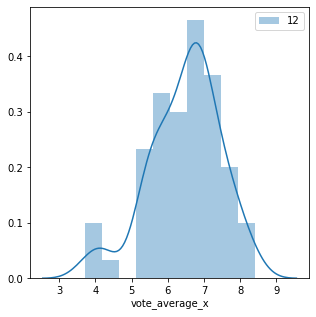

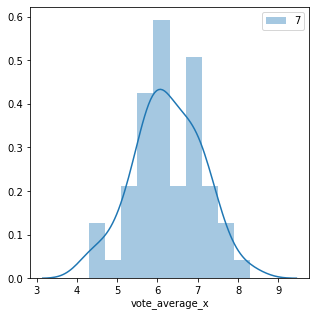

In [20]:
for cat in categories_of_further_interest:
    
    if cat != 'month':
    
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:11].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]


    else:
        
        top10 = list(df_vote_average[cat].loc[df_vote_average[cat] != 'na'].value_counts()[0:13].index)
        
        top10_df = df_vote_average.loc[df_vote_average[cat].isin(top10)]
    
    for i in top10:    
        exec(f"print(cat, ',', i, stats.normaltest(list({cat}[({cat}[cat + '_outlier_flag'] == False) & ({cat}[cat] == i)]['vote_average_x'])))")
        
        fig = plt.figure(figsize = (5, 5))
        exec(f"sns.distplot({cat}[({cat}[cat + '_outlier_flag'] == False) & ({cat}[cat] == i)]['vote_average_x'], bins = 10, label=i)")
        plt.legend()

### `en_int_lang`

In [21]:
en_int_lang_no_outliers = en_int_lang.loc[en_int_lang['en_int_lang_outlier_flag'] == False, ['en_int_lang', 'vote_average_x']]

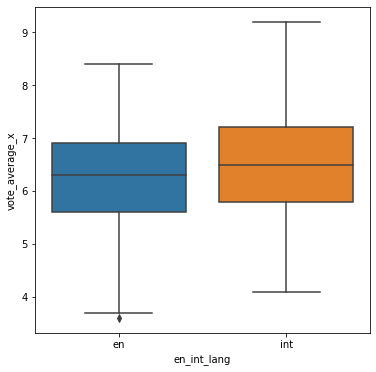

In [22]:
fig = plt.subplots(figsize = (6,6))
sns.boxplot(x='en_int_lang', y='vote_average_x', data=en_int_lang_no_outliers);

In [23]:
data1 = en_int_lang[(en_int_lang['en_int_lang'] == 'en') & (en_int_lang['en_int_lang_outlier_flag'] == False)]['vote_average_x']
data2 = en_int_lang[(en_int_lang['en_int_lang'] == 'int') & (en_int_lang['en_int_lang_outlier_flag'] == False)]['vote_average_x']

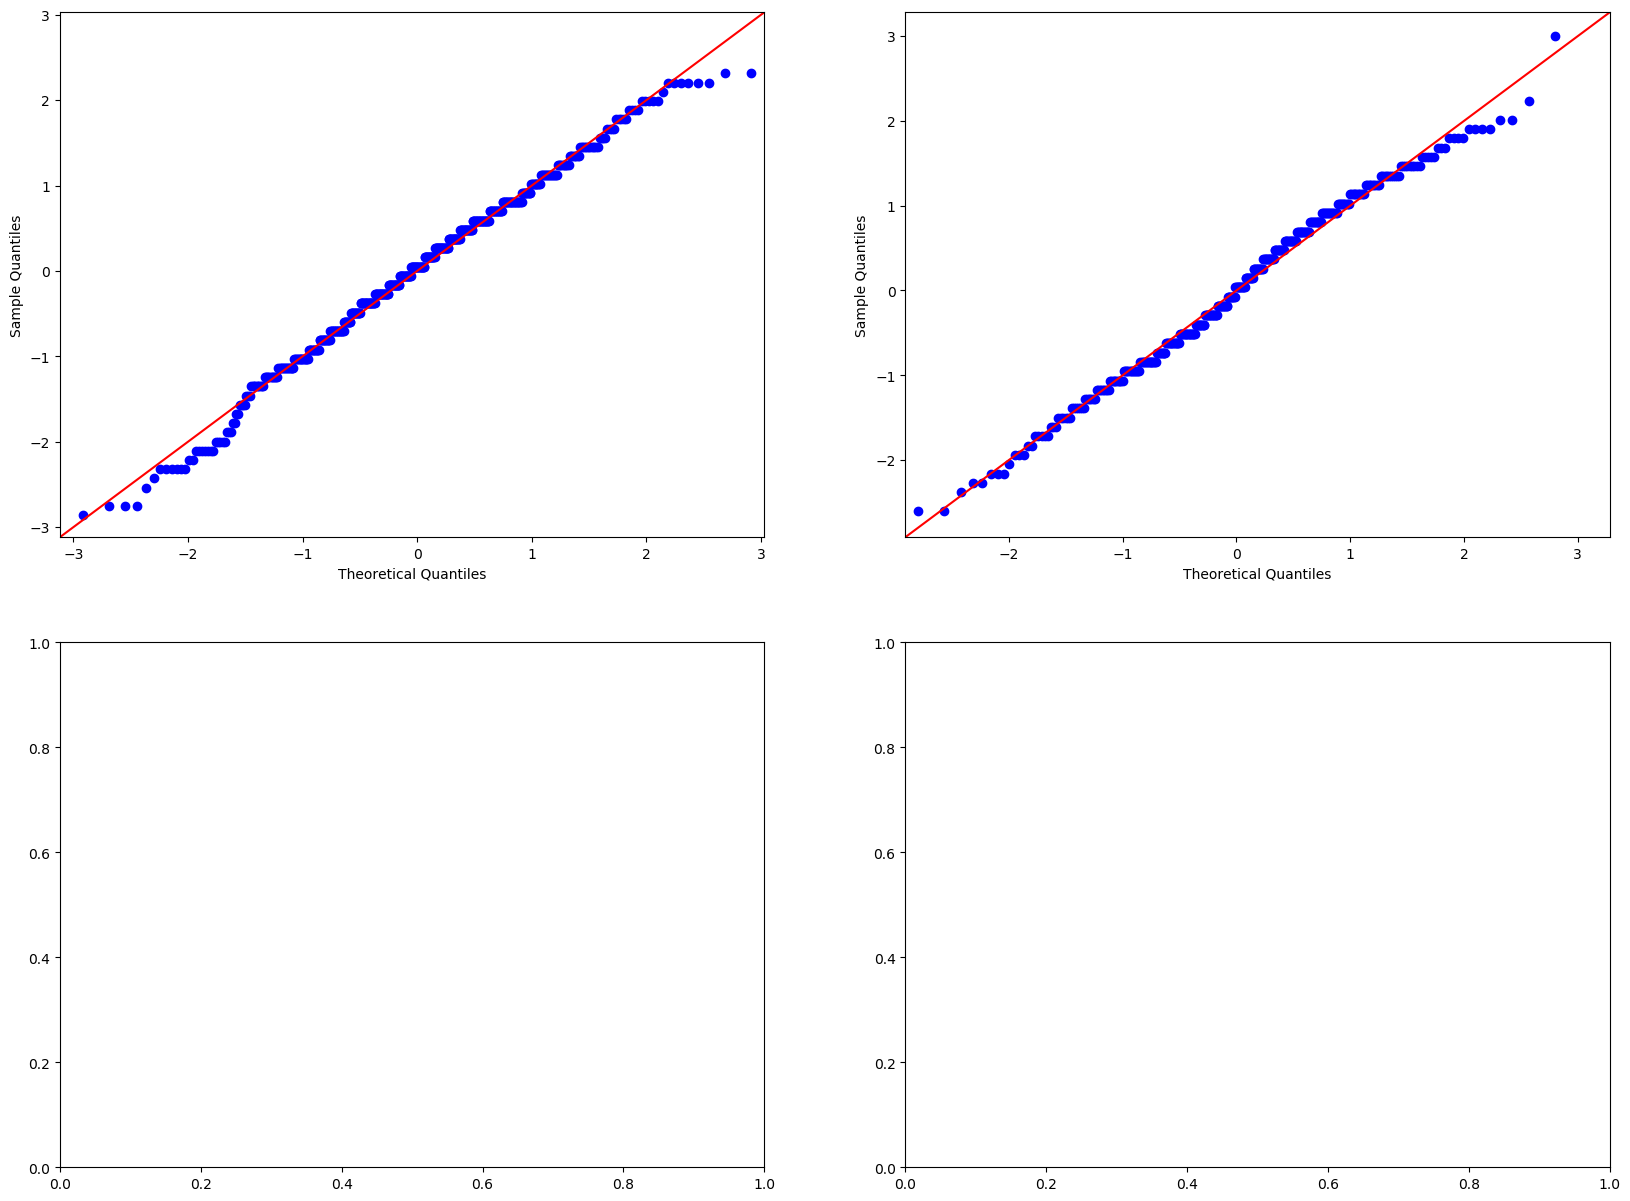

In [24]:
plt.style.use('default')
fig2, axes2 = plt.subplots(2, 2, figsize = (20, 15))
axes2.shape

for n in range(1,3):

    i = 'data'+str(n)

    row = (n-1)//2
    col = (n-1)%2
    exec(f'probplot = sm.ProbPlot({i}, fit=True)')
    ax = axes2[row][col]
    probplot.qqplot(line='45', ax = axes2[row][col])

## Question 1 - Is there a difference in rating between English language movies and international language movies?

#### Null Hypothesis (H0):                Mean Rating of en = Mean Rating of int
#### Alternative Hypothesis (H1):    Mean Rating  of en ≠ Mean Rating of int

In [25]:
en_language = en_int_lang[(en_int_lang['en_int_lang'] == 'en') & (en_int_lang['en_int_lang_outlier_flag'] == False)]['vote_average_x']
int_language = en_int_lang[(en_int_lang['en_int_lang'] == 'int') & (en_int_lang['en_int_lang_outlier_flag'] == False)]['vote_average_x']

The samples are unevenly sized and the sample sizes are very large. For this reason a 2-tailed welch's t-test was performed to test the Alternative Hypothesis.

In [26]:
t = welch_ttest(en_language, int_language)
#df = welch_df(en_language, int_language)
#print(t, df)


 Welch's t-test= -3.5230 
 p-value = 0.00044948 
 Degrees of Freedom= 847.0933


In [27]:
welch_ttest(en_language, int_language)


 Welch's t-test= -3.5230 
 p-value = 0.00044948 
 Degrees of Freedom= 847.0933


In [28]:
#p_value(en_language, int_language, two_sided=True)

In [29]:
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [30]:
c_d = Cohen_d(en_language, int_language)

In [31]:
print('effect size: ', c_d)

effect size:  -0.23192738184711365


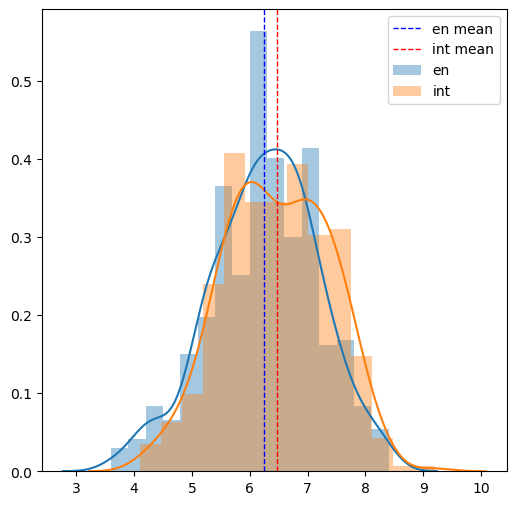

In [32]:
fig = plt.subplots(figsize = (6,6))
sns.distplot(list(en_language), label = 'en')
sns.distplot(list(int_language), label = 'int')
plt.axvline(en_language.mean(), color='blue', linestyle='--', lw=1,label='en mean')
plt.axvline(int_language.mean(), color='red', linestyle='--', lw=1,label='int mean')
plt.legend();

In [33]:
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=c_d, nobs1=390, alpha=.05, ratio = 556/390)

0.9391681564548459

so while we are able to reject the null hypothesis the very small effect size indicate that there is no meaningful difference in the average ratings for English language movies and non-English language movies.

### `genre_ids`

In [34]:
genre_ids.loc[genre_ids['genre_ids_outlier_flag'] == False]['genre_ids'].value_counts()

Comedy|                  126
Drama|                    90
Drama|Comedy|             57
Documentary|              27
Comedy|Romance|           26
Horror|Thriller|          25
Drama|Romance|            17
Drama|Comedy|Romance|     17
Thriller|                 17
Horror|                   16
Drama|History|            12
Name: genre_ids, dtype: int64

the top 3 genres based on the number of movies released are: Comedy, Drama and Drama|Comedy ('Dramadey')

In [35]:
genre_ids_no_outliers = genre_ids.loc[genre_ids['genre_ids_outlier_flag'] == False, ['genre_ids', 'vote_average_x']]

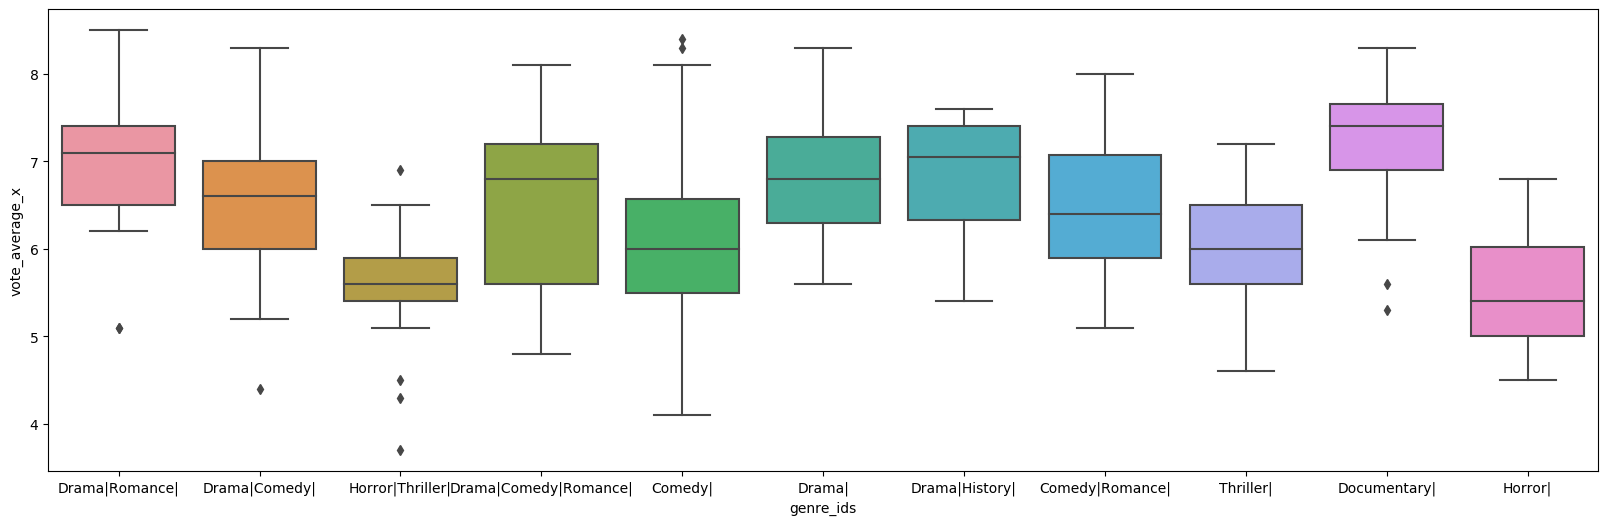

In [36]:
fig = plt.subplots(figsize = (20,6))
sns.boxplot(x='genre_ids', y='vote_average_x', data=genre_ids_no_outliers);

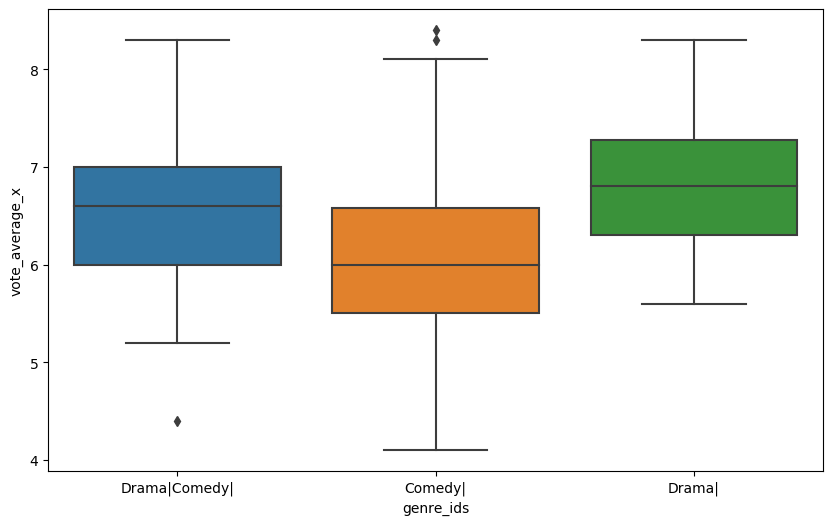

In [37]:
fig = plt.subplots(figsize = (10,6))
sns.boxplot(x='genre_ids', y='vote_average_x', data=genre_ids_no_outliers.loc[genre_ids_no_outliers['genre_ids'].isin(['Comedy|', 'Drama|', 'Drama|Comedy|'])]);

## Question 2 - Is there a difference in rating between the genres Drama, Comedy and 'Dramadey' (Drama/Comedy)?

#### Null Hypothesis (H0):                Mean Rating of Drama|Comedy = Mean Rating of Drama = Mean Rating of Comedy
#### Alternative Hypothesis (H1):    Mean Rating of Drama > Mean Rating of Comedy < Mean Rating of Drama|Comedy

In [38]:
drama_comedy_genres = ['Comedy|', 'Drama|', 'Drama|Comedy|']
genre_table = genre_ids.loc[(genre_ids['genre_ids'].isin(drama_comedy_genres)) & (genre_ids['genre_ids_outlier_flag'] == False), ['genre_ids', 'vote_average_x']]
formula = 'vote_average_x ~ C(genre_ids)'
lm = ols(formula, genre_table).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)    

                  sum_sq     df          F        PR(>F)
C(genre_ids)   33.733384    2.0  28.512357  5.830832e-12
Residual      159.720462  270.0        NaN           NaN


In [39]:
anova(formula, genre_table)

,sum_sq,df,mean_sq,eta_sq,omega_sq,F,PR(>F)
C(genre_ids),33.733384,2.0,16.866692,0.174374,0.167746,28.512357,5.830832e-12
Residual,159.720462,270.0,0.591557,NaN,NaN,NaN,NaN


In [40]:
tab = genre_table[genre_table['genre_ids'].isin(['Comedy|','Drama|','Drama|Comedy|'])]
mc = MultiComparison(tab['vote_average_x'], tab['genre_ids'])
mc_results = mc.tukeyhsd()
print(mc_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1     group2    meandiff p-adj  lower  upper  reject
----------------------------------------------------------
Comedy|        Drama|   0.7856  0.001 0.5354 1.0357   True
Comedy| Drama|Comedy|   0.4994  0.001 0.2101 0.7888   True
 Drama| Drama|Comedy|  -0.2861 0.0734 -0.593 0.0207  False
----------------------------------------------------------


null hypothesis between Comedy and Drama rejected <br>
null hypothesis between Comedy and Drama|Comedy rejected <br>
null hypothesis between Drama and Drama|Comedy **NOT** rejected

In [41]:
comedy = list(genre_table.loc[genre_table['genre_ids'] == drama_comedy_genres[0]]['vote_average_x'])
drama = list(genre_table.loc[genre_table['genre_ids'] == drama_comedy_genres[1]]['vote_average_x'])
drama_comedy = list(genre_table.loc[genre_table['genre_ids'] == drama_comedy_genres[2]]['vote_average_x'])

In [42]:
print('difference in means: ', np.array(comedy).mean() - np.array(drama).mean())
print('comedy_language sample size: ', len(comedy))
print('drama_language sample size: ', len(drama))

difference in means:  -0.7855555555555567
comedy_language sample size:  126
drama_language sample size:  90


In [43]:
#p_value(np.array(comedy), np.array(drama), two_sided=True)

In [44]:
c_d = Cohen_d(np.array(comedy), np.array(drama))

In [45]:
print('effect size: ', c_d)

effect size:  -1.023992198839946


In [46]:
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=c_d, nobs1=120, alpha=.05, ratio = 90/126)

1.0

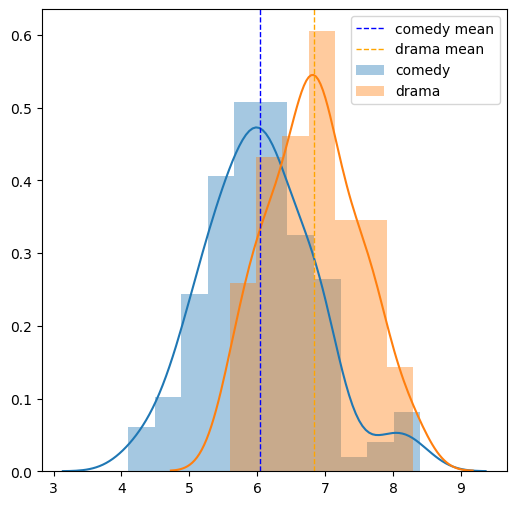

In [47]:
fig = plt.subplots(figsize = (6,6))
sns.distplot(comedy, label = 'comedy')
sns.distplot(drama, label = 'drama')
plt.axvline(np.array(comedy).mean(), color='blue', linestyle='--', lw=1,label='comedy mean')
plt.axvline(np.array(drama).mean(), color='orange', linestyle='--', lw=1,label='drama mean')
plt.legend();

In [48]:
#p_value(np.array(comedy), np.array(drama_comedy), two_sided=True)

In [49]:
c_d = Cohen_d(np.array(comedy), np.array(drama_comedy))

In [50]:
print('effect size: ', c_d)

effect size:  -0.6187686444544191


In [51]:
power_analysis = TTestIndPower()
power_analysis.solve_power(effect_size=c_d, nobs1=120, alpha=.05, ratio = 90/120)

0.9929925119951566

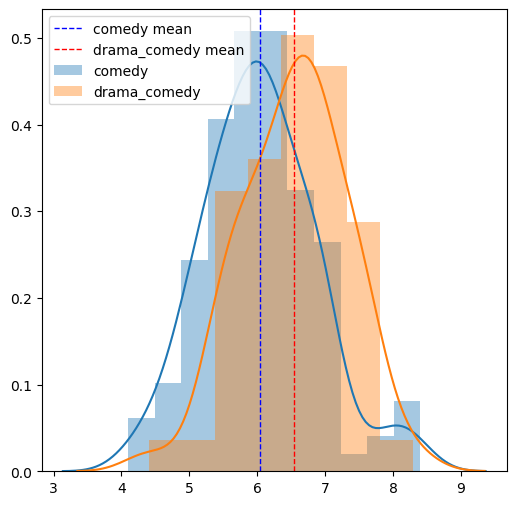

In [52]:
fig = plt.subplots(figsize = (6,6))
sns.distplot(comedy, label = 'comedy')
sns.distplot(drama_comedy, label = 'drama_comedy')
plt.axvline(np.array(comedy).mean(), color='blue', linestyle='--', lw=1,label='comedy mean')
plt.axvline(np.array(drama_comedy).mean(), color='red', linestyle='--', lw=1,label='drama_comedy mean')
plt.legend();

Non Parametric - Kruskal - Wallis H test

In [53]:
stat, p = kruskal(comedy, drama, drama_comedy)
print('Statistics=%.3f, p=%.9f' % (stat, p))

Statistics=49.855, p=0.000000000


In [54]:
sp.posthoc_dunn([comedy, drama, drama_comedy], p_adjust = 'holm')

,1,2,3
1,-1.000000e+00,1.549592e-11,0.000209
2,1.549592e-11,-1.000000e+00,0.049080
3,2.091607e-04,4.908012e-02,-1.000000


# Revenue, budget and profitability

In [55]:
df_reduced.shape

(10000, 16)

In [56]:
df_revenue = df_reduced[(df_reduced.revenue != 0) & (df_reduced.budget != 0)]

In [57]:
df_revenue = df_revenue.loc[df_revenue.budget.notnull()]

In [58]:
df_revenue = df_revenue.loc[df_revenue.revenue.notnull()]

In [59]:
df_revenue.reset_index(inplace=True)

In [60]:
df_revenue.drop(columns ='index', inplace=True)

In [61]:
df_revenue.sample(20)

,popularity,vote_count_x,vote_average_x,release_date,original_language_x,genre_ids,belongs_to_collection,budget,production_companies,production_countries,revenue,day_of_week,month,quarter,en_int_lang,collection
69,23.345,1664.0,5.8,2018-11-21,en,Adventure|Action|Thriller|,na,100000000.0,Appian Way,US,73260114.0,2,11,4,en,Collection
6,56.386,7898.0,6.6,2018-09-28,en,Action|Science Fiction|,Venom Collection,116000000.0,Avi Arad Productions,CN,855013954.0,4,9,3,en,Collection
178,0.600,0.0,0.0,2018-01-09,en,Drama|,na,100000.0,Farabi Cinema Foundation,IR,1500000.0,1,1,1,en,Collection
114,12.430,1017.0,5.8,2018-02-02,en,Fantasy|Horror|Thriller|Mystery|,na,3500000.0,Imagination Design Works,AU,25091816.0,4,2,1,en,Collection
177,0.655,0.0,0.0,2018-03-09,fa,Drama|,na,15000.0,Gooya Film,IR,1500000.0,4,3,1,int,Collection
144,5.143,205.0,5.8,2018-01-18,it,Comedy|,na,8166084.0,Walt Disney Studios Motion Pictures,na,8475827.0,3,1,1,int,Collection
219,0.687,2.0,6.5,2018-04-14,en,Drama|Action|,na,13444.0,RISE Wrestling,US,7666.0,5,4,2,en,Collection
236,1.034,2.0,5.0,2018-12-07,en,Thriller|Mystery|,na,50.0,Joker Studios,US,270.0,4,12,4,en,Collection
255,0.600,0.0,0.0,2018-02-12,en,Adventure|Crime|Documentary|,na,5.0,Dale Dudes Productions,US,5.0,0,2,1,en,Collection
39,15.940,2784.0,6.8,2018-11-21,en,Drama|,Creed Collection,50000000.0,Metro-Goldwyn-Mayer,US,137944327.0,2,11,4,en,Collection


## Question 3 - Is there a difference in rating between profitable movies and unprofitable movies?

## Hypothesis:

### H0: no significant difference in budget between profitable and unprofitable movies
### Ha: there is a significant difference in budget between profitable and unprofitable movies

In [62]:
df_revenue['profitable'] = df_revenue.revenue - df_revenue.budget

df_revenue.loc[df_revenue.profitable > 0, 'profitable'] = 1
df_revenue.loc[df_revenue.profitable <= 0, 'profitable'] = 0

In [63]:
df_revenue.head()

,popularity,vote_count_x,vote_average_x,release_date,original_language_x,genre_ids,belongs_to_collection,budget,production_companies,production_countries,revenue,day_of_week,month,quarter,en_int_lang,collection,profitable
0,82.250,16683.0,8.3,2018-04-25,en,Adventure|Action|Science Fiction|,The Avengers Collection,300000000.0,Marvel Studios,US,2.046240e+09,2,4,2,en,Collection,1.0
1,38.895,14192.0,7.4,2018-02-13,en,Adventure|Fantasy|Action|Science Fiction|,Black Panther Collection,200000000.0,Marvel Studios,US,1.346739e+09,1,2,1,en,Collection,1.0
2,31.957,6878.0,6.5,2018-06-06,en,Adventure|Action|Science Fiction|,Jurassic Park Collection,170000000.0,Amblin Entertainment,US,1.303460e+09,2,6,2,en,Collection,1.0
3,30.431,7607.0,7.5,2018-06-14,en,Adventure|Animation|Action|Family|,The Incredibles Collection,200000000.0,Walt Disney Pictures,US,1.241891e+09,3,6,2,en,Collection,1.0
4,31.991,7849.0,6.8,2018-12-07,en,Adventure|Fantasy|Action|,Aquaman Collection,160000000.0,DC Comics,AU,1.143689e+09,4,12,4,en,Collection,1.0


In [64]:
df_revenue.sample(20)

,popularity,vote_count_x,vote_average_x,release_date,original_language_x,genre_ids,belongs_to_collection,budget,production_companies,production_countries,revenue,day_of_week,month,quarter,en_int_lang,collection,profitable
235,0.913,1.0,0.0,2018-09-23,de,Drama|,na,1508.0,A.N. pictures,DE,8.630000e+02,6,9,3,int,Collection,0.0
218,0.900,0.0,0.0,2018-02-20,fa,Drama|,na,10000.0,Simaye Mehr,IR,1.000000e+04,1,2,1,int,Collection,0.0
26,23.348,3538.0,5.9,2018-08-09,en,Horror|Action|Science Fiction|,na,150000000.0,Apelles Entertainment,CN,3.159601e+08,3,8,3,en,Collection,1.0
30,17.499,4439.0,7.0,2018-01-10,en,Action|Science Fiction|,The Maze Runner Collection,62000000.0,Gotham Group,US,2.848816e+08,2,1,1,en,Collection,1.0
130,10.165,837.0,6.2,2018-02-21,en,Horror|Thriller|,na,1500000.0,Regency Enterprises,US,1.429360e+07,2,2,1,en,Collection,1.0
76,15.992,2477.0,7.9,2018-03-23,en,Adventure|Animation|Comedy|,na,62770198.0,Studio Babelsberg,US,6.420762e+07,4,3,1,en,Collection,1.0
66,19.874,1632.0,6.7,2018-06-27,en,Drama|Action|Thriller|Crime|,Sicario Collection,35000000.0,Black Label Media,US,7.583668e+07,2,6,2,en,Collection,1.0
39,15.940,2784.0,6.8,2018-11-21,en,Drama|,Creed Collection,50000000.0,Metro-Goldwyn-Mayer,US,1.379443e+08,2,11,4,en,Collection,1.0
84,8.336,365.0,5.8,2018-05-05,en,Action|Thriller|Crime|,na,6000000.0,Will Packer Productions,US,4.907800e+07,5,5,2,en,Collection,1.0
224,0.882,0.0,0.0,2018-12-17,en,Comedy|Western|Family|,na,3000.0,Silverstrand Cinemas,US,3.000000e+03,0,12,4,en,Collection,0.0


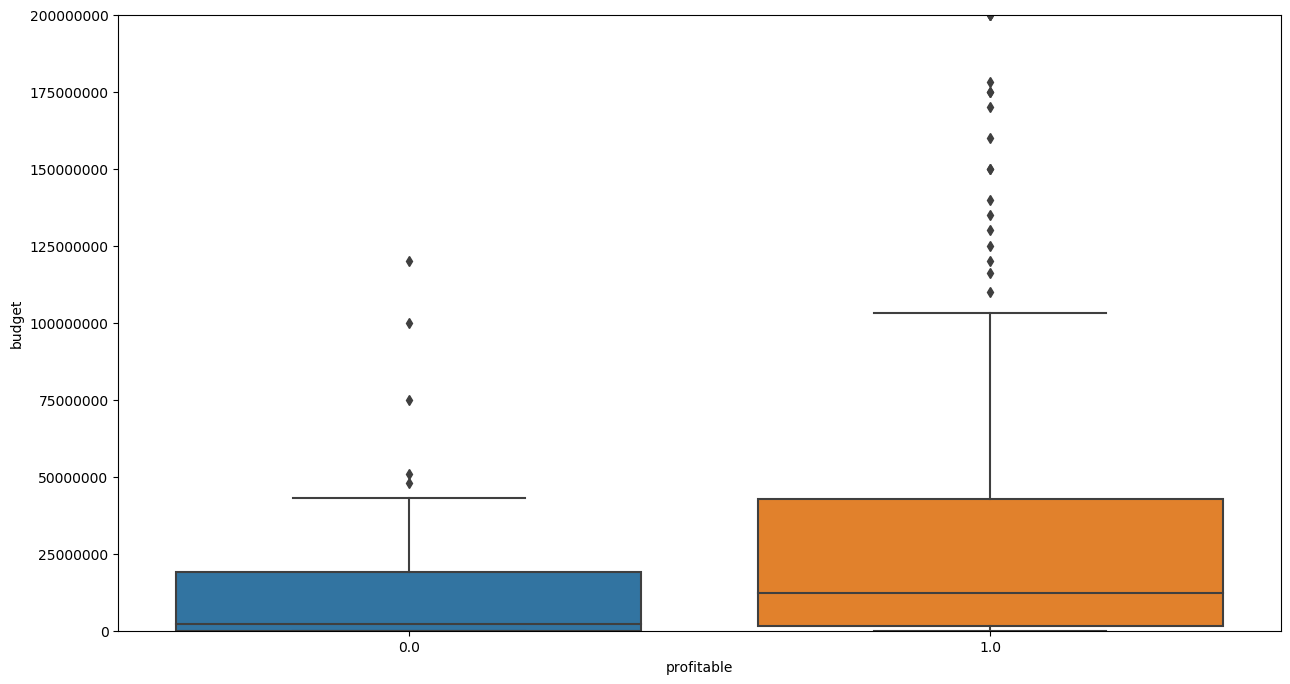

In [65]:
plt.figure(figsize=(15,8))
plt.ylim(top=200000000)
plt.ticklabel_format(style='plain')
sns.boxplot(x="profitable", y="budget", data=df_revenue)
plt.show()

In [66]:
df_profitable = df_revenue[df_revenue['profitable'] ==1]
df_not_profitable = df_revenue[df_revenue['profitable'] ==0]

df_revenue.groupby('profitable')['budget'].describe()

,count,mean,std,min,25%,50%,75%,max
profitable,,,,,,,,
0.0,86.0,1.301122e+07,2.208137e+07,5.0,3250.0,2170000.0,19000000.00,120000000.0
1.0,174.0,3.581609e+07,5.420961e+07,1.0,1501177.5,12250000.0,42802059.75,300000000.0


In [67]:
# Levene's test for homogeneity of variance  is significant 
# so should conduct Welch's T-Test instead of students T-Test
stats.levene(df_profitable['budget'], df_not_profitable['budget'])

LeveneResult(statistic=13.066944691228477, pvalue=0.0003613344765608587)

In [68]:
# residuals not normally distributed so should use nonparametric tests

print(stats.shapiro(df_profitable['revenue']))
print(stats.shapiro(df_not_profitable['revenue']))

(0.5553759336471558, 6.572560254773633e-21)
(0.5672418475151062, 1.578704919883659e-14)


In [69]:

#mann whitney test at alpha = 0.05

mann_whitney_u(df_profitable['budget'], df_not_profitable['budget'])

Statistics=4902.500, p=0.000
Different distribution (reject H0)


#### p < 0.05 so can reject H0:
   therefore there is a significant difference in budget between profitable and unprofitable films

## Question 4 - Is there a difference in rating between movies based on the day/period of release?

In [70]:
df_revenue.loc[df_revenue.day_of_week == 0, 'day_of_week'] = 'Mon'
df_revenue.loc[df_revenue.day_of_week == 1, 'day_of_week'] = 'Tue'
df_revenue.loc[df_revenue.day_of_week == 2, 'day_of_week'] = 'Wed'
df_revenue.loc[df_revenue.day_of_week == 3, 'day_of_week'] = 'Thu'
df_revenue.loc[df_revenue.day_of_week == 4, 'day_of_week'] = 'Fri'
df_revenue.loc[df_revenue.day_of_week == 5, 'day_of_week'] = 'Sat'
df_revenue.loc[df_revenue.day_of_week == 6, 'day_of_week'] = 'Sun'

# data1 = df_revenue['revenue'][df_revenue['day_of_week'] == 0]
# data2 = df_revenue['revenue'][df_revenue['day_of_week'] == 1]
# data3 = df_revenue['revenue'][df_revenue['day_of_week'] == 2]
# data4 = df_revenue['revenue'][df_revenue['day_of_week'] == 3]
# data5 = df_revenue['revenue'][df_revenue['day_of_week'] == 4]
# data6 = df_revenue['revenue'][df_revenue['day_of_week'] == 5]
# data7 = df_revenue['revenue'][df_revenue['day_of_week'] == 6]

## Hypothesis :

### H0: no significant difference in revenue between films released at different times
### Ha: there is a significant difference in revenue between films released at different times

This will be broken down into three hypotheses: month, quarter and day of the week

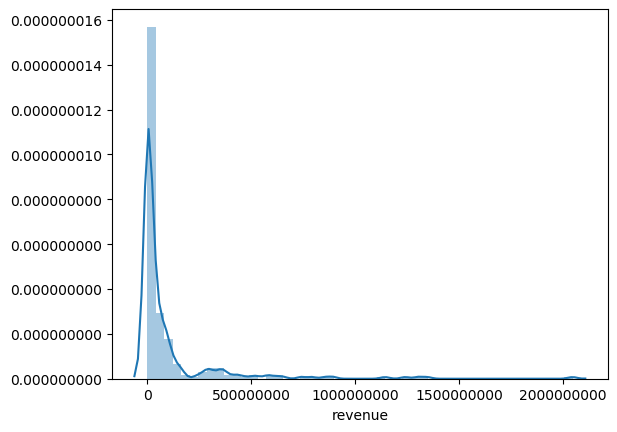

In [71]:
plt.ticklabel_format(style='plain')
sns.distplot(df_revenue['revenue'])

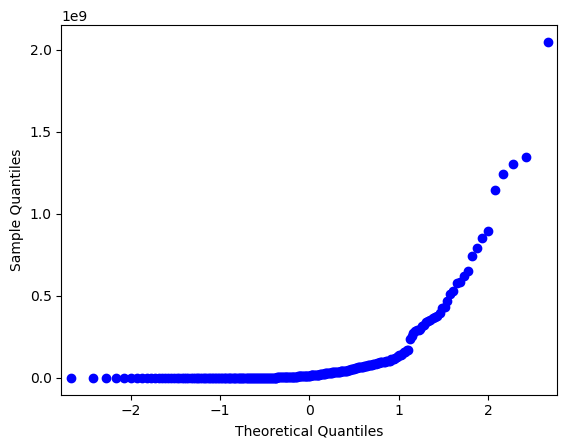

In [72]:
# qq plot shows not normally distributed
sm.qqplot(df_revenue['revenue'])
pylab.show()

In [73]:
stats.shapiro(df_revenue['revenue'])

(0.4618762135505676, 2.69166447542904e-27)

In [74]:
data1 = df_revenue['revenue'][df_revenue['quarter'] == 1]
data2 = df_revenue['revenue'][df_revenue['quarter'] == 2]
data3 = df_revenue['revenue'][df_revenue['quarter'] == 3]
data4 = df_revenue['revenue'][df_revenue['quarter'] == 4]

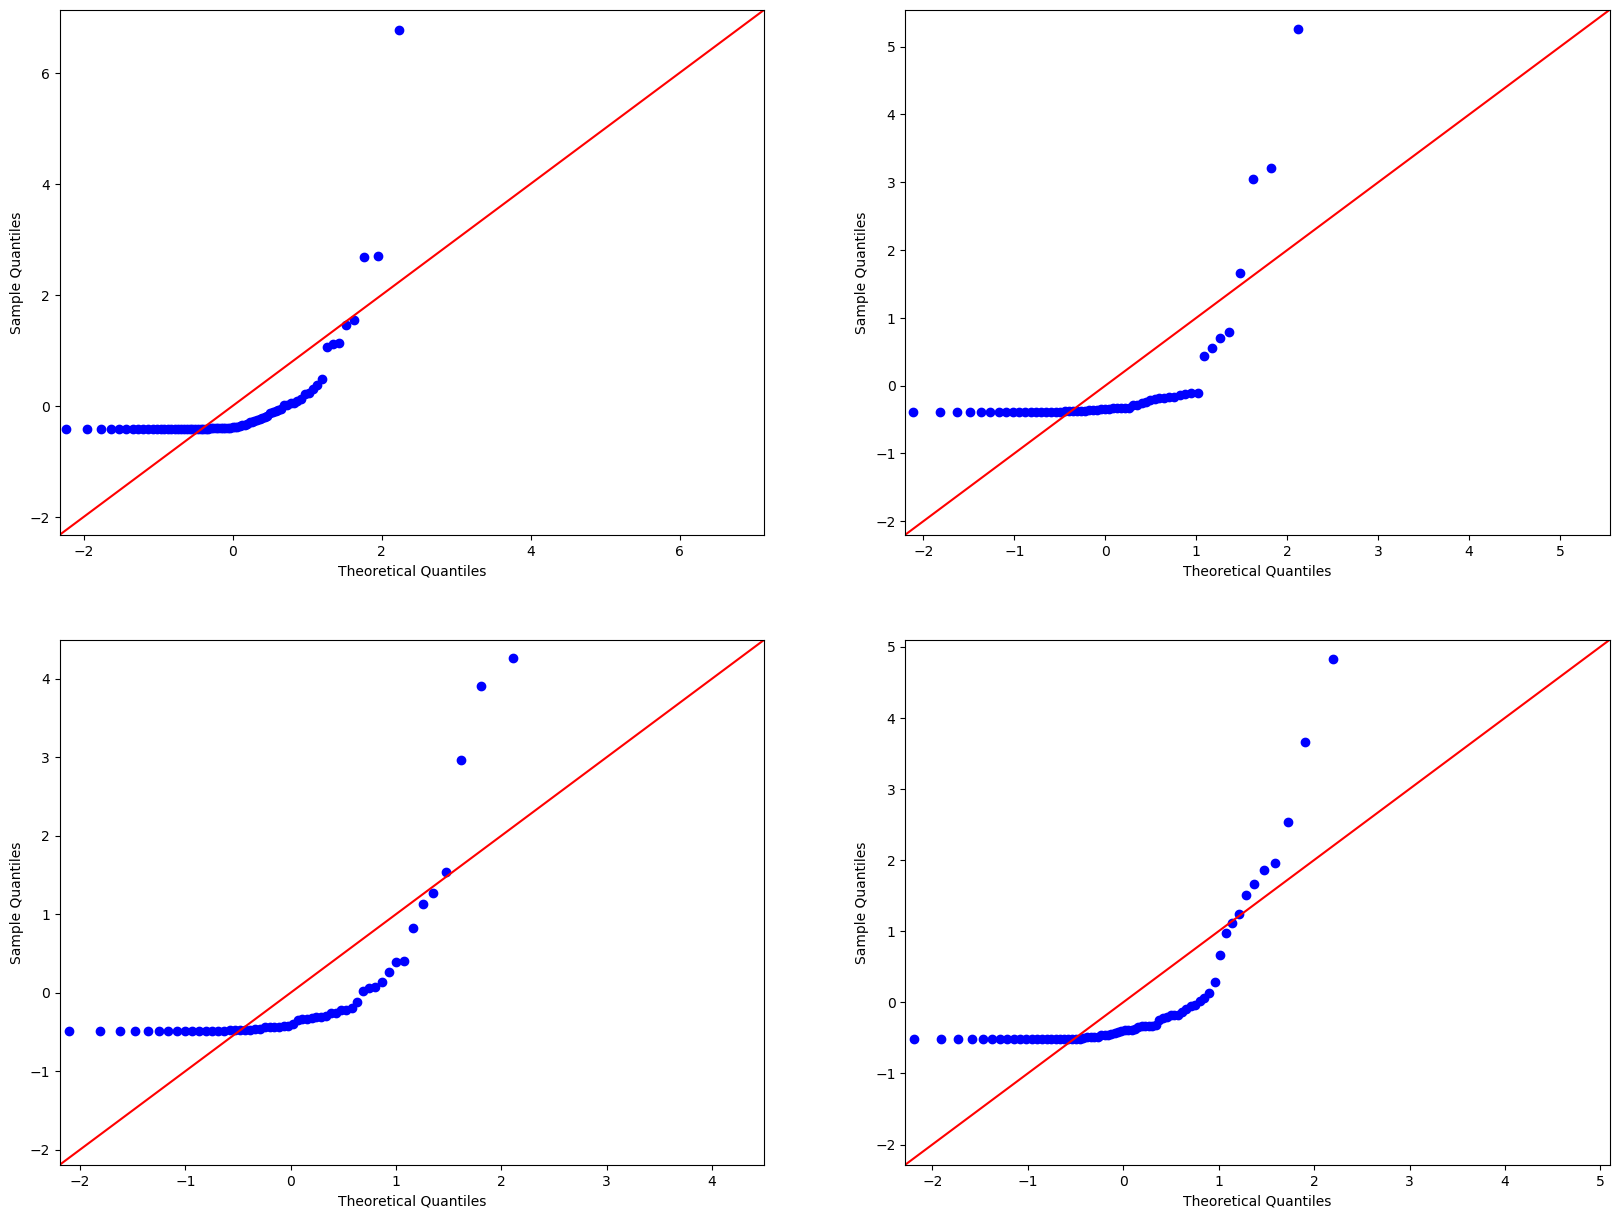

In [75]:
fig2, axes2 = plt.subplots(2, 2, figsize = (20, 15))
axes2.shape

for n in range(1,5):

    i = 'data'+str(n)

    row = (n-1)//2
    col = (n-1)%2
    exec(f'probplot = sm.ProbPlot({i}, fit=True)')
    ax = axes2[row][col]
    probplot.qqplot(line='45', ax = axes2[row][col])

In [76]:
print(stats.shapiro(data1))
print(stats.shapiro(data2))
print(stats.shapiro(data3))
print(stats.shapiro(data4))

(0.4457833170890808, 1.5465218607010845e-15)
(0.42829442024230957, 1.4706962590035205e-13)
(0.535047173500061, 4.695506570367991e-12)
(0.5714941024780273, 5.543234057533986e-13)


In [77]:
kw_test(data1,data2,data3,data4)

Statistics=3.710, p=0.294
Same distributions (fail to reject H0)


In [78]:
data1 = df_revenue['revenue'][df_revenue['month'] == 1]
data2 = df_revenue['revenue'][df_revenue['month'] == 2]
data3 = df_revenue['revenue'][df_revenue['month'] == 3]
data4 = df_revenue['revenue'][df_revenue['month'] == 4]
data5 = df_revenue['revenue'][df_revenue['month'] == 5]
data6 = df_revenue['revenue'][df_revenue['month'] == 6]
data7 = df_revenue['revenue'][df_revenue['month'] == 7]
data8 = df_revenue['revenue'][df_revenue['month'] == 8]
data9 = df_revenue['revenue'][df_revenue['month'] == 9]
data10 = df_revenue['revenue'][df_revenue['month'] == 10]
data11 = df_revenue['revenue'][df_revenue['month'] == 11]
data12 = df_revenue['revenue'][df_revenue['month'] == 12]

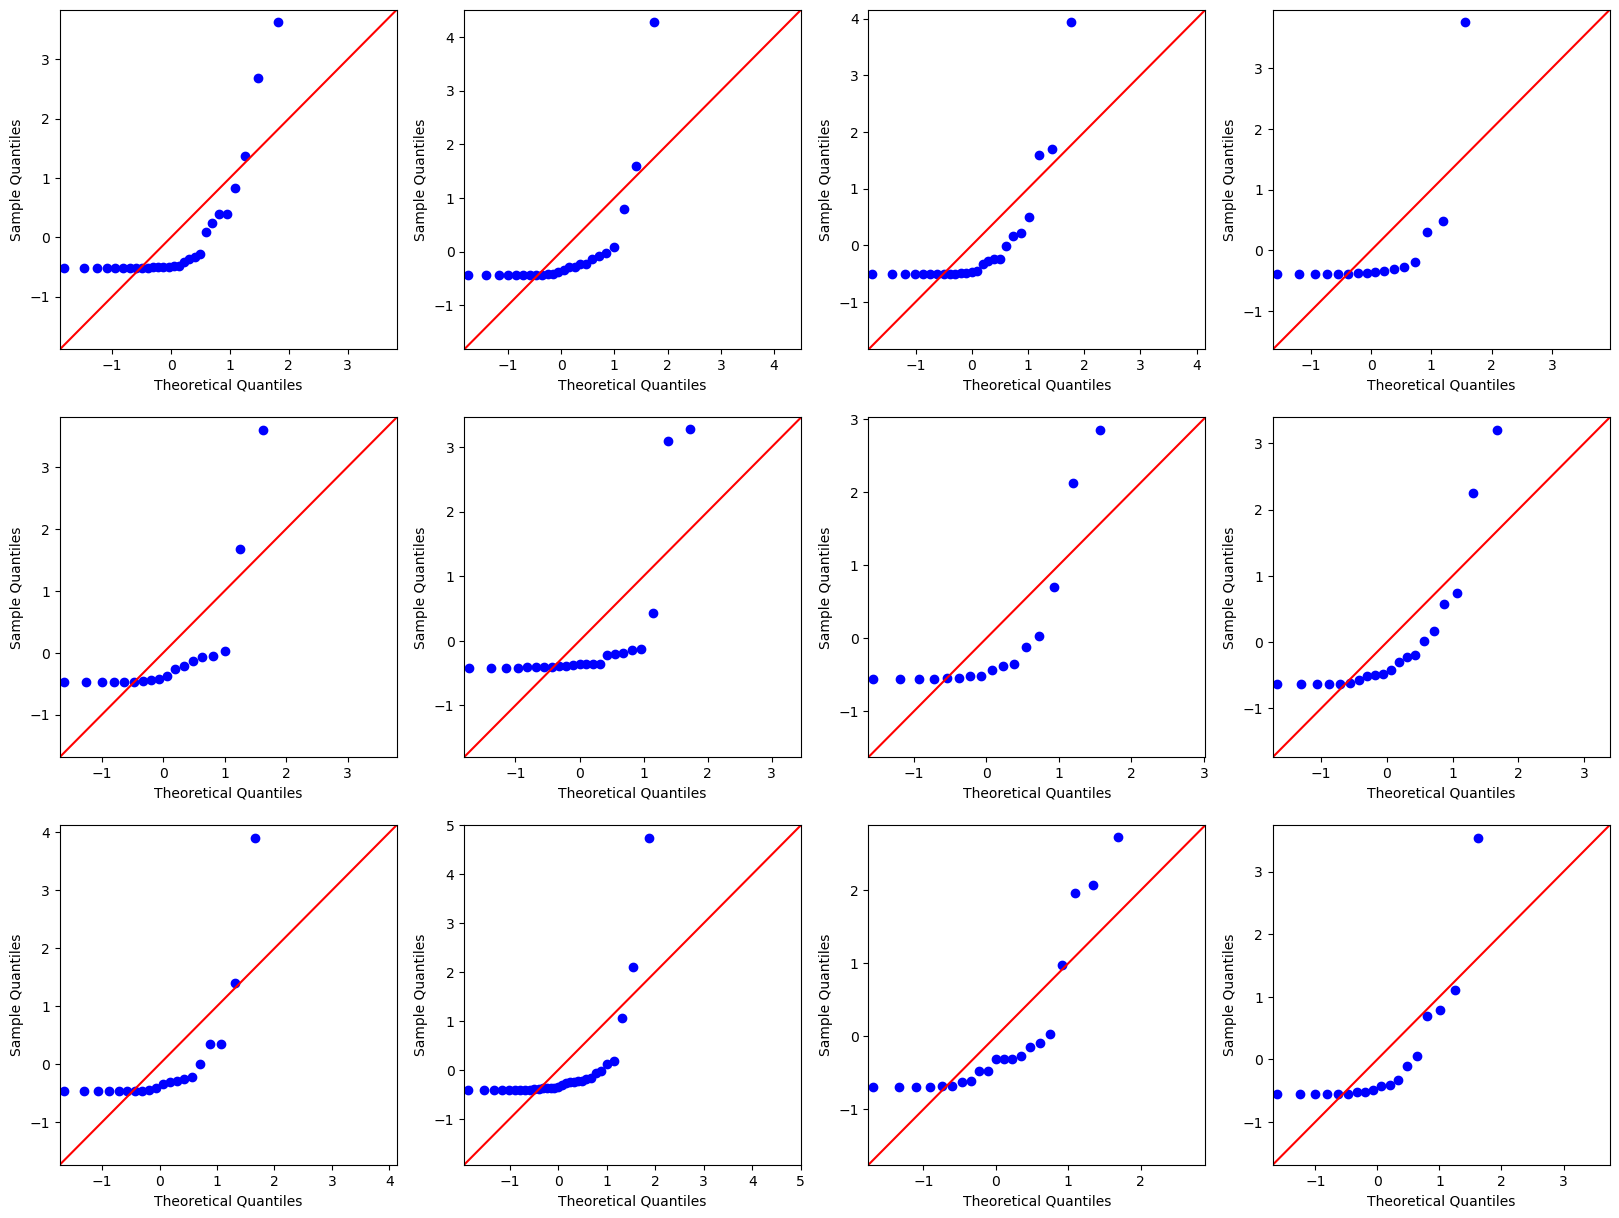

In [79]:
fig2, axes2 = plt.subplots(3, 4, figsize = (20, 15))
axes2.shape

for n in range(1,13):

    i = 'data'+str(n)

    row = (n-1)//4
    col = (n-1)%4
    exec(f'probplot = sm.ProbPlot({i}, fit=True)')
    ax = axes2[row][col]
    probplot.qqplot(line='45', ax = axes2[row][col])

In [80]:
print(stats.shapiro(data1))
print(stats.shapiro(data2))
print(stats.shapiro(data3))
print(stats.shapiro(data4))
print(stats.shapiro(data5))
print(stats.shapiro(data6))
print(stats.shapiro(data7))
print(stats.shapiro(data8))
print(stats.shapiro(data9))
print(stats.shapiro(data10))
print(stats.shapiro(data11))
print(stats.shapiro(data12))

(0.5872861742973328, 1.0291143581753204e-07)
(0.4744981527328491, 3.2174181541222424e-08)
(0.5671519041061401, 1.8436843163271988e-07)
(0.42540156841278076, 5.426601887847937e-07)
(0.5154024362564087, 1.0935867749140016e-06)
(0.44105851650238037, 2.455123926381475e-08)
(0.6127083897590637, 2.138791751349345e-05)
(0.6581008434295654, 1.2543159755296074e-05)
(0.5129270553588867, 4.169946521415113e-07)
(0.4349515438079834, 7.960379022620145e-10)
(0.6895983219146729, 2.048513852059841e-05)
(0.6117869019508362, 8.87636542756809e-06)


None of the qqplots, nor the Shapiro tests, by month of year, indicate normality. <br>
Therefore, we will use non-parametric tests to test for differences between the mean revenue by month:

In [81]:
kw_test(data1,data2,data3,data4,data5,data6,data7,data8,data9,data10,data11,data12)

Statistics=9.011, p=0.621
Same distributions (fail to reject H0)


In [82]:
data_m = df_revenue['revenue'][df_revenue['day_of_week'] == 'Mon']
data_t = df_revenue['revenue'][df_revenue['day_of_week'] == 'Tue']
data_w = df_revenue['revenue'][df_revenue['day_of_week'] == 'Wed']
data_th = df_revenue['revenue'][df_revenue['day_of_week'] == 'Thu']
data_f = df_revenue['revenue'][df_revenue['day_of_week'] == 'Fri']
data_s = df_revenue['revenue'][df_revenue['day_of_week'] == 'Sat']
data_su = df_revenue['revenue'][df_revenue['day_of_week'] == 'Sun']

In [83]:
kw_test(data_m,data_t,data_w,data_th,data_f,data_s,data_su)

Statistics=32.482, p=0.000
Different distributions (reject H0)


In [84]:
data_list = [data_m,data_t,data_w,data_th,data_f,data_s,data_su]

dunn_test(data_list)

,1,2,3,4,5,6,7
1,-1.000000,1.000000,0.002807,0.012901,0.252334,1.000000,1.000000
2,1.000000,-1.000000,0.130513,0.382736,1.000000,1.000000,0.889961
3,0.002807,0.130513,-1.000000,1.000000,0.110578,0.145988,0.007297
4,0.012901,0.382736,1.000000,-1.000000,0.477059,0.349721,0.024061
5,0.252334,1.000000,0.110578,0.477059,-1.000000,1.000000,0.252334
6,1.000000,1.000000,0.145988,0.349721,1.000000,-1.000000,1.000000
7,1.000000,0.889961,0.007297,0.024061,0.252334,1.000000,-1.000000


In [85]:
x=df_revenue['revenue'][df_revenue['day_of_week'] == 'Wed']
y=df_revenue['revenue'][df_revenue['day_of_week'] != 'Wed']

In [86]:
mann_whitney_u(x,y)

Statistics=4057.500, p=0.001
Different distribution (reject H0)


In [87]:
# estimation of standardised effect score
4057.5/(len(x)*len(y))

0.3598669623059867

In [95]:
stat, p = mannwhitneyu(x, y, alternative='greater')
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=7217.500, p=0.001


In [96]:
# estimation of standardised effect score if you assum one sided mann whitney test
stat/(len(x)*len(y))

0.6401330376940133

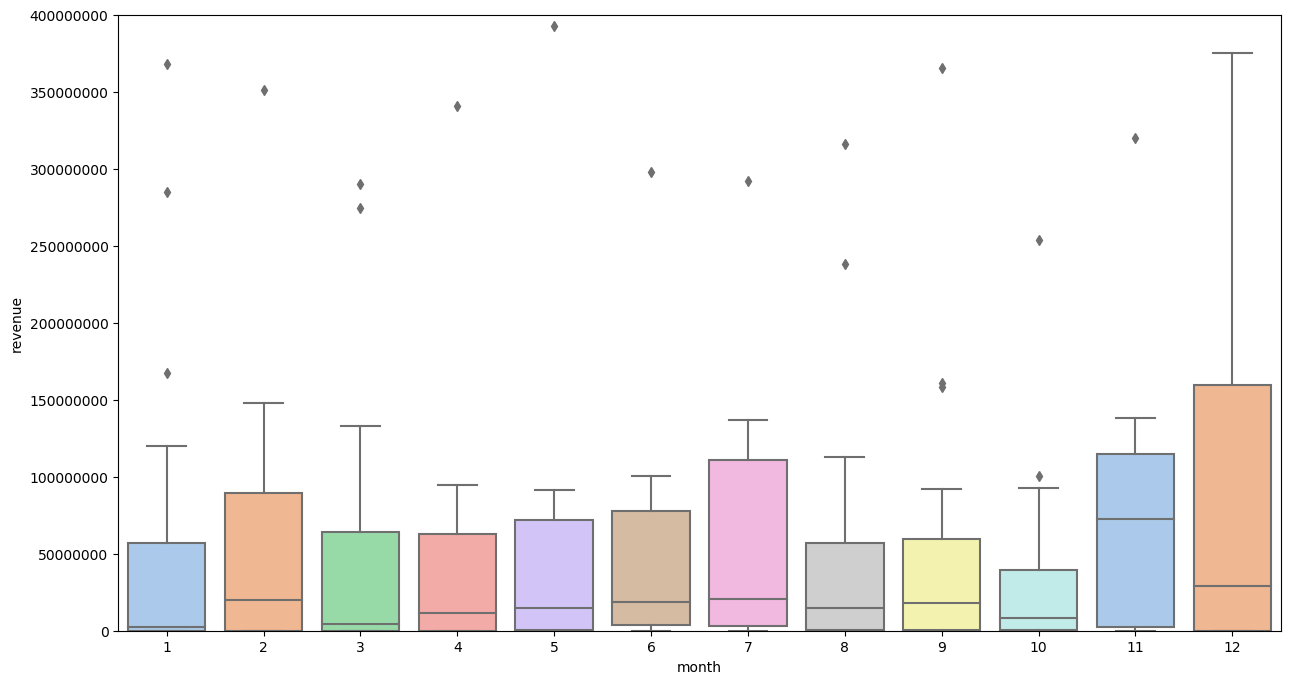

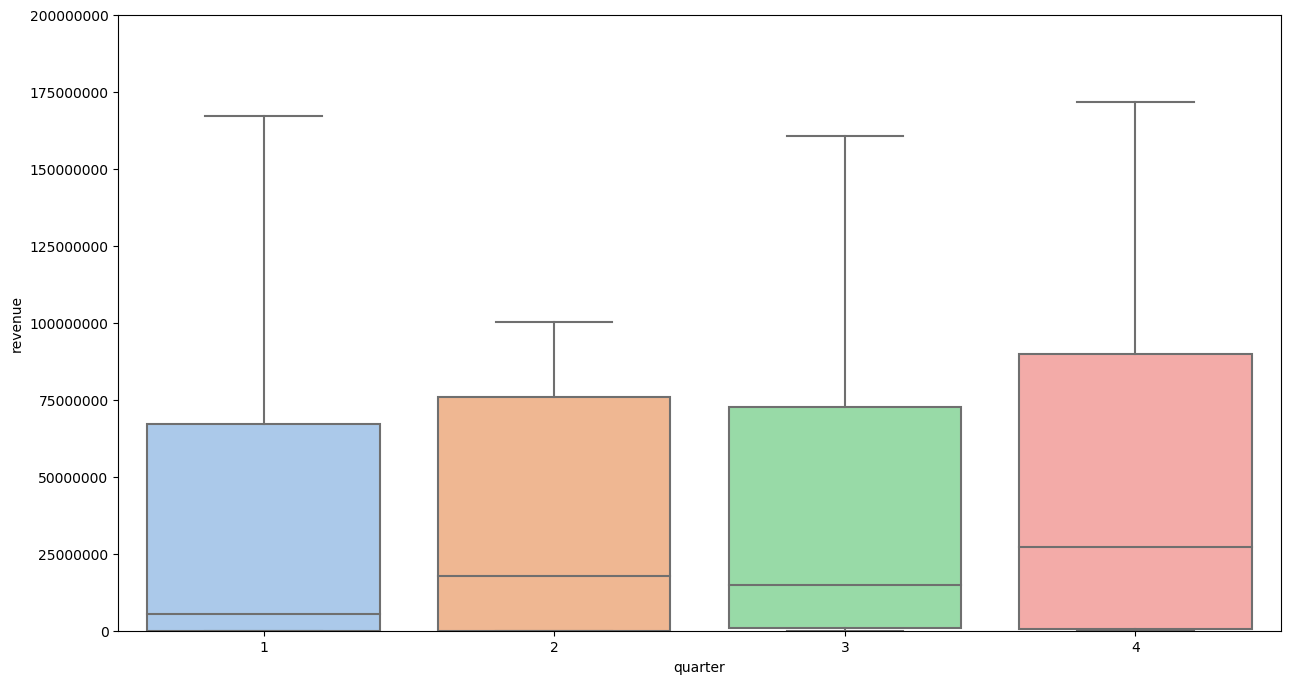

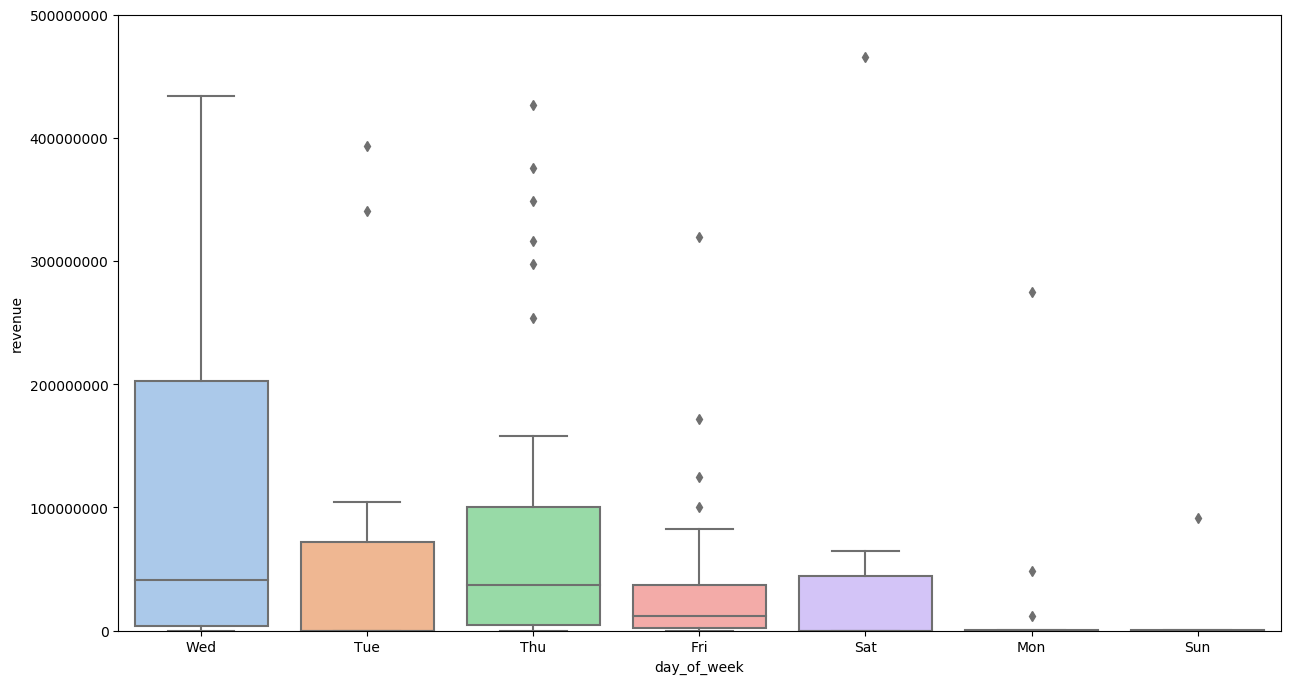

In [90]:

plt.figure(figsize=(15,8))
plt.ylim(top=400000000)
plt.ticklabel_format(style='plain')
sns.boxplot(x="month", y="revenue", data=df_revenue, palette='pastel')

plt.figure(figsize=(15,8))
plt.ylim(top=200000000)
plt.ticklabel_format(style='plain')
sns.boxplot(x="quarter", y="revenue", data=df_revenue, palette='pastel')

plt.figure(figsize=(15,8))
plt.ylim(top=500000000)
plt.ticklabel_format(style='plain')
sns.boxplot(x="day_of_week", y="revenue", data=df_revenue,  palette='pastel')

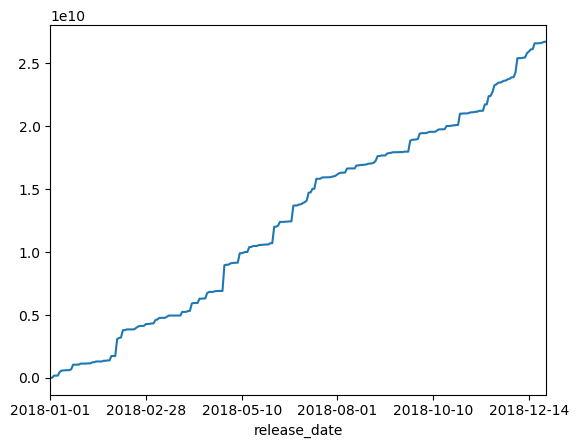

In [91]:
ser = df_revenue.set_index('release_date')
ser['revenue'].sort_index().cumsum().plot()

In [92]:
ser_df = ser['revenue'].sort_index().cumsum().reset_index()

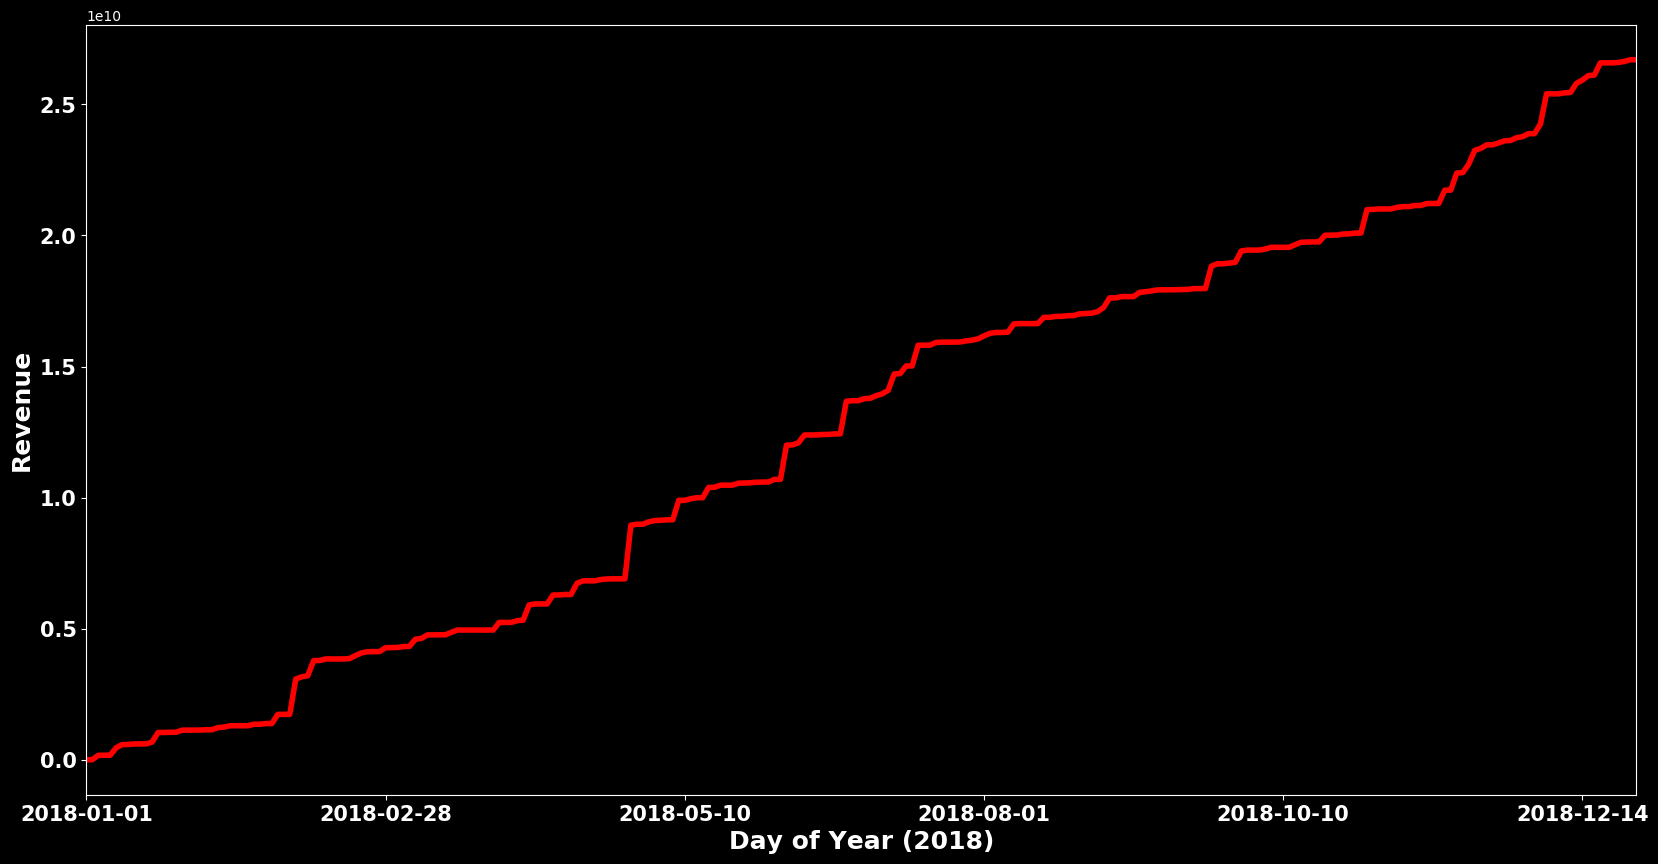

In [93]:
plt.style.use("dark_background")

plt.figure(figsize = (20, 10))
g = ser['revenue'].sort_index().cumsum().plot(linewidth = 4, color = 'red')
plt.xlabel('Day of Year (2018)', fontsize=18, weight = 'bold')
plt.ylabel('Revenue', fontsize=18, weight = 'bold')
plt.xticks(fontsize = 15, weight = 'bold')
plt.yticks(fontsize = 15, weight = 'bold');